#### **Install Optuna**

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 23.0 MB/s eta 0:00:00


#### **Load Libraries**

In [ ]:
# Essential imports and setup
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# TensorFlow and Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, DenseNet121, InceptionV3, Xception, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU available: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU")

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

GPU available: 1 device(s)
TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2


#### **Define Paths & Data Loading**

In [ ]:
# NIH Dataset paths
TRAIN_PATH = "/content/drive/MyDrive/NIH_processed/train"
TEST_PATH = "/content/drive/MyDrive/NIH_processed/test"

labels = ['normal', 'pneumonia']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath   label
0  /content/drive/MyDrive/NIH_processed/train/nor...  normal
1  /content/drive/MyDrive/NIH_processed/train/nor...  normal
2  /content/drive/MyDrive/NIH_processed/train/nor...  normal
3  /content/drive/MyDrive/NIH_processed/train/nor...  normal
4  /content/drive/MyDrive/NIH_processed/train/nor...  normal

The shape of The Train data is: (5320, 2)
The shape of The Test data is: (1784, 2)


In [ ]:
# NIH Dataset paths
TRAIN_PATH = "/content/drive/MyDrive/NIH_processed/train"
TEST_PATH = "/content/drive/MyDrive/NIH_processed/test"

### **Data Preparation**

In [ ]:
# data generators with augmentation and validation split (80/20)
BATCH_SIZE = 32
INIT_LR = 0.001
EPOCHS = 15

def create_generators(preprocess_func, target_size):
    # Create main generator with validation split
    main_generator = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2
    )

    # Train generator (80% of data)
    trainGen = main_generator.flow_from_directory(
        TRAIN_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        subset='training',
        seed=123
    )

    # Validation generator (20% of data)
    validationGen = main_generator.flow_from_directory(
        TRAIN_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE,
        subset='validation',
        seed=123
    )

    # Test generator (separate directory)
    testGen = ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_directory(
        TEST_PATH,
        class_mode="categorical",
        target_size=target_size,
        color_mode="rgb",
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    # Calculate actual counts
    train_count = trainGen.samples
    val_count = validationGen.samples
    test_count = testGen.samples

    print(f"Data counts: Train={train_count}, Val={val_count}, Test={test_count}")

    return trainGen, validationGen, testGen, train_count, val_count


# -----------------------------------------------------#
# Explicitly create and assign testGen after calling the function
# We need to call create_generators with appropriate args.
if 'model_configs' in locals():

    first_model_config = model_configs[0]
    trainGen, validationGen, testGen, train_count, val_count = create_generators(
        first_model_config['preprocess_func'],
        first_model_config['target_size']
    )
else:
    print("Error: 'model_configs' not found. Cannot create data generators. Please run Cell E.")

Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784


#### **Geaometric Augmentation Samples**

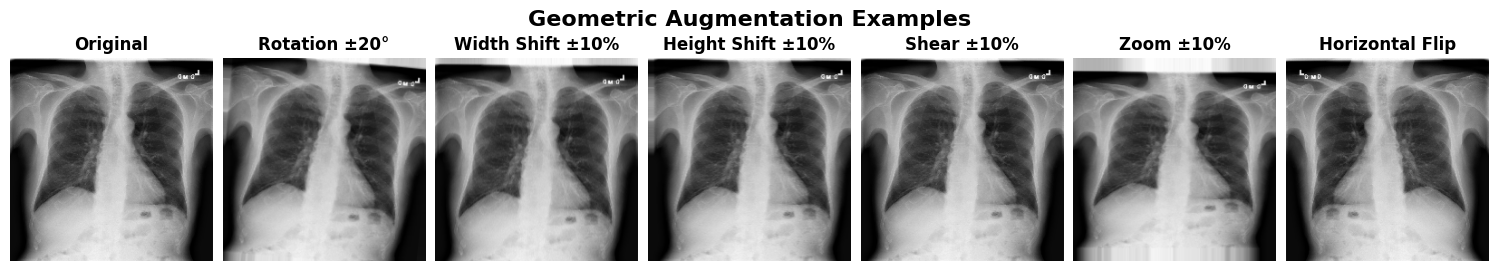

Augmentation Parameters Used in Your Code:
Rotation range: ±20 degrees
Width shift range: ±10%
Height shift range: ±10%
Shear range: ±10%
Zoom range: ±10%
Horizontal flip: Enabled
Fill mode: Nearest


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load a sample image
sample_image_path = "/content/drive/MyDrive/NIH_processed/val/normal/00000143_004.png"
img = load_img(sample_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create individual augmentation generators for each transformation
augmentations = [
    ("Original", ImageDataGenerator()),
    ("Rotation ±20°", ImageDataGenerator(rotation_range=20, fill_mode="nearest")),
    ("Width Shift ±10%", ImageDataGenerator(width_shift_range=0.1, fill_mode="nearest")),
    ("Height Shift ±10%", ImageDataGenerator(height_shift_range=0.1, fill_mode="nearest")),
    ("Shear ±10%", ImageDataGenerator(shear_range=0.1, fill_mode="nearest")),
    ("Zoom ±10%", ImageDataGenerator(zoom_range=0.1, fill_mode="nearest")),
    ("Horizontal Flip", ImageDataGenerator(horizontal_flip=True, fill_mode="nearest"))
]

# Generate augmented images
augmented_images = []
titles = []

for title, generator in augmentations:
    if title == "Original":
        augmented = img_array[0]
    else:
        # For reproducible results
        np.random.seed(42)
        augmented = generator.random_transform(img_array[0])

    augmented_images.append(augmented)
    titles.append(title)

# Plot the images in a single row, nicely packed
n = len(augmented_images)
fig, axes = plt.subplots(1, n, figsize=(n * 2.2, 3))  # one row, n cols

for i, (ax, im, title) in enumerate(zip(axes, augmented_images, titles)):
    ax.imshow(im.astype('uint8'))
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.axis('off')

plt.suptitle('Geometric Augmentation Examples', fontsize=16, fontweight='bold')

# Reduce horizontal space between subplots so images sit closer together
plt.subplots_adjust(wspace=0.05, top=0.85, left=0.02, right=0.98)

plt.savefig('/content/drive/MyDrive/NIH_processed/augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Print augmentation parameters
print("Augmentation Parameters Used in Your Code:")
print(f"Rotation range: ±20 degrees")
print(f"Width shift range: ±10%")
print(f"Height shift range: ±10%")
print(f"Shear range: ±10%")
print(f"Zoom range: ±10%")
print(f"Horizontal flip: Enabled")
print(f"Fill mode: Nearest")

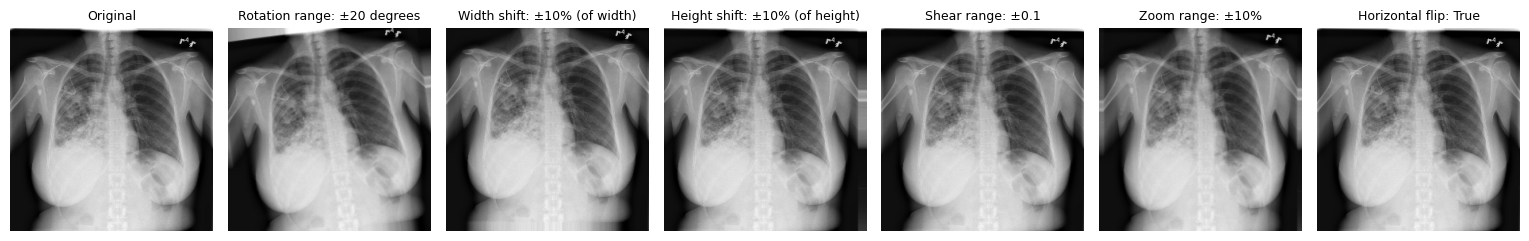

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# ---------- CONFIG ----------
image_path = "/content/drive/MyDrive/NIH_processed/train/pneumonia/00000261_007.png"
TARGET_SIZE = (256, 256)   # change to your model's target_size if needed
BATCH_SIZE = 1
SEED = 123
# ----------------------------

# load image (keeps original colours)
img_pil = load_img(image_path, color_mode="rgb", target_size=TARGET_SIZE)
x_raw = img_to_array(img_pil)              # shape (h,w,3), dtype=float32, values ~0-255
x = x_raw.reshape((1,) + x_raw.shape)      # shape (1,h,w,3)

# define augmentations (matching your generator params)
gens = [
    ("Rotation range: ±20 degrees",
        ImageDataGenerator(rotation_range=20, fill_mode="nearest")),
    ("Width shift: ±10% (of width)",
        ImageDataGenerator(width_shift_range=0.1, fill_mode="nearest")),
    ("Height shift: ±10% (of height)",
        ImageDataGenerator(height_shift_range=0.1, fill_mode="nearest")),
    ("Shear range: ±0.1",
        ImageDataGenerator(shear_range=0.1, fill_mode="nearest")),
    ("Zoom range: ±10%",
        ImageDataGenerator(zoom_range=0.1, fill_mode="nearest")),
    ("Horizontal flip: True",
        ImageDataGenerator(horizontal_flip=True, fill_mode="nearest")),
]

# Collect original + single sample from each generator
images = [x_raw.astype("uint8")]
titles = ["Original"]

for title, datagen in gens:
    flow = datagen.flow(x, batch_size=BATCH_SIZE, seed=SEED, shuffle=False)
    batch = next(flow)            # one augmented sample
    aug = batch[0]                # may be float32 in 0-255 range
    # Ensure displayable uint8 with clipped range (keeps colours)
    aug_uint8 = np.clip(aug, 0, 255).astype("uint8")
    images.append(aug_uint8)
    titles.append(title)

# Plot as single long row (Original + 6 augmentations = 7 images)
n = len(images)
fig, axes = plt.subplots(1, n, figsize=(n * 2.2, 3))
if n == 1:
    axes = [axes]

for ax, im, t in zip(axes, images, titles):
    ax.imshow(im)            # im is uint8 RGB
    ax.axis("off")
    ax.set_title(t, fontsize=9)

plt.tight_layout()
plt.show()

#### **Model Creation**

In [ ]:
#  Model Creation
# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

# Enhanced model creation with Monte Carlo Dropout
def create_resnet50_model(input_shape=(224, 224, 3), classes=2):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_densenet121_model(input_shape=(224, 224, 3), classes=2):
    base_model = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_inceptionv3_model(input_shape=(299, 299, 3), classes=2):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_xception_model(input_shape=(299, 299, 3), classes=2):
    base_model = Xception(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_mobilenetv2_model(input_shape=(224, 224, 3), classes=2):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers[:-15]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Monte Carlo Dropout
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# Cell E: Model Configurations
model_configs = [
    {
        'name': 'ResNet50',
        'create_func': create_resnet50_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': resnet_preprocess
    },
    {
        'name': 'DenseNet121',
        'create_func': create_densenet121_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': densenet_preprocess
    },
    {
        'name': 'InceptionV3',
        'create_func': create_inceptionv3_model,
        'input_shape': (299, 299, 3),
        'target_size': (299, 299),
        'preprocess_func': inception_preprocess
    },
    {
        'name': 'Xception',
        'create_func': create_xception_model,
        'input_shape': (299, 299, 3),
        'target_size': (299, 299),
        'preprocess_func': xception_preprocess
    },
    {
        'name': 'MobileNetV2',
        'create_func': create_mobilenetv2_model,
        'input_shape': (224, 224, 3),
        'target_size': (224, 224),
        'preprocess_func': mobilenet_preprocess
    }
]

In [ ]:
# Model Parameter Counts
model_creators = {
    'ResNet50': create_resnet50_model,
    'DenseNet121': create_densenet121_model,
    'InceptionV3': create_inceptionv3_model,
    'Xception': create_xception_model,
    'MobileNetV2': create_mobilenetv2_model
}

for name, build_fn in model_creators.items():
    # instantiate with default input_shape and classes
    model = build_fn()

    total_params = model.count_params()
    trainable_params = sum(
        K.count_params(w) for w in model.trainable_weights
    )
    non_trainable_params = sum(
        K.count_params(w) for w in model.non_trainable_weights
    )

    print(f"{name}:")
    print(f"  Total params         : {total_params:,}")
    print(f"  Trainable params     : {trainable_params:,}")
    print(f"  Non-trainable params : {non_trainable_params:,}\n")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet50:
  Total params         : 24,112,770
  Trainable params     : 9,456,386
  Non-trainable params : 14,656,384

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121:
  Total params         : 7,300,418
  Trainable params     : 904,322
  Non-trainable params : 6,396,096

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
InceptionV3:
  Total params         : 22,327,842
  Trainable params     : 5,681,090
  Non-trainable params : 16,646,752

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Xception:
  Total params         : 21,386,538
  Trainable params     : 9,465,410
  Non-trainable params : 11,921,128

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2:
  Total params         : 2,586,434
  Trainable params     : 1,368,450
  Non-trainable params : 1,217,984



In [ ]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# ensure labels list exists, e.g. labels = ['pneumonia', 'normal']
label_to_index = {label: idx for idx, label in enumerate(labels)}
print("Label index:", label_to_index)

# map dataframe labels to integer indices
train_label_indices = train['label'].map(label_to_index).values.astype(int)

# compute balanced class weights (integer keys for Keras)
_classes = np.unique(train_label_indices)
_weights = compute_class_weight(class_weight='balanced', classes=_classes, y=train_label_indices)
classWeight = dict(zip(_classes.tolist(), _weights.tolist()))

print("Calculated Class Weights:")
print(classWeight)

Label index: {'normal': 0, 'pneumonia': 1}
Calculated Class Weights:
{0: 0.6537232735315802, 1: 2.1262989608313347}


#### **Model Training**

Training individual models...

Training ResNet50...
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784
Steps per epoch: 134, Validation steps: 34
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7194 - loss: 1.9077
Epoch 1: val_loss improved from inf to 0.27352, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/ResNet50_weights-001-0.2735.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 693s 5s/step - accuracy: 0.7196 - loss: 1.8997 - val_accuracy: 0.7827 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.7746 - loss: 0.0567
Epoch 2: val_loss improved from 0.27352 to 0.03888, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/ResNet50_weights-002-0.0389.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7746 - loss: 0.0566 - val_a

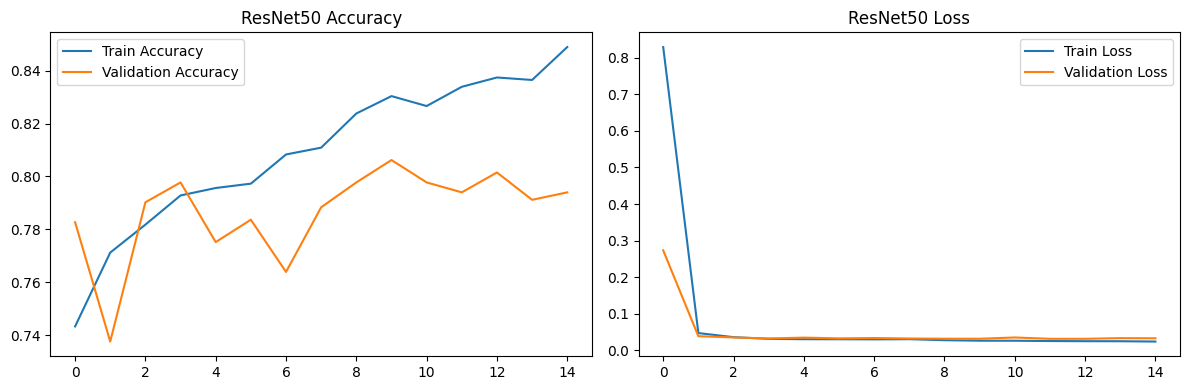

ResNet50 - Test Accuracy: 78.36%, Test Loss: 0.0316

Training DenseNet121...
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784
Steps per epoch: 134, Validation steps: 34
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6977 - loss: 2.1321
Epoch 1: val_loss improved from inf to 0.23211, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/DenseNet121_weights-001-0.2321.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.6980 - loss: 2.1246 - val_accuracy: 0.7705 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.7679 - loss: 0.1603
Epoch 2: val_loss improved from 0.23211 to 0.05961, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/DenseNet121_weights-002-0.0596.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy

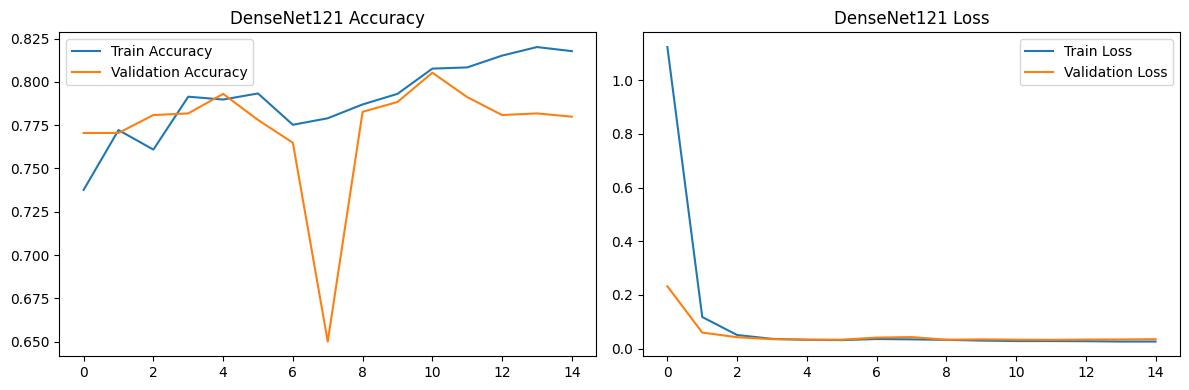

DenseNet121 - Test Accuracy: 78.03%, Test Loss: 0.0304

Training InceptionV3...
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784
Steps per epoch: 134, Validation steps: 34
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7309 - loss: 1.7689
Epoch 1: val_loss improved from inf to 0.03898, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/InceptionV3_weights-001-0.0390.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7310 - loss: 1.7611 - val_accuracy: 0.7742 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7784 - loss: 0.0374
Epoch 2: val_loss improved from 0.03898 to 0.03509, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/InceptionV3_weights-002-0.0351.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy

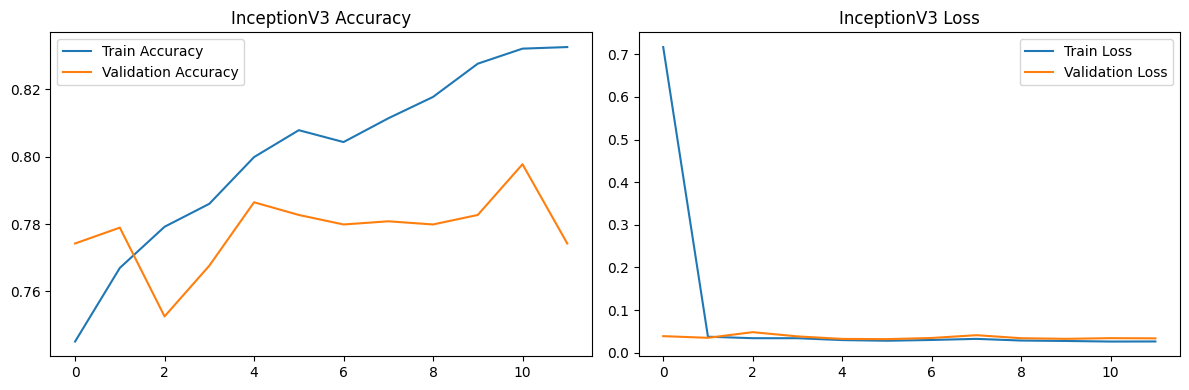

InceptionV3 - Test Accuracy: 76.91%, Test Loss: 0.0313

Training Xception...
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784
Steps per epoch: 134, Validation steps: 34
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7468 - loss: 1.5434
Epoch 1: val_loss improved from inf to 0.04194, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/Xception_weights-001-0.0419.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7469 - loss: 1.5362 - val_accuracy: 0.7648 - val_loss: 0.0419 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7810 - loss: 0.0300
Epoch 2: val_loss improved from 0.04194 to 0.03176, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/Xception_weights-002-0.0318.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.7810 

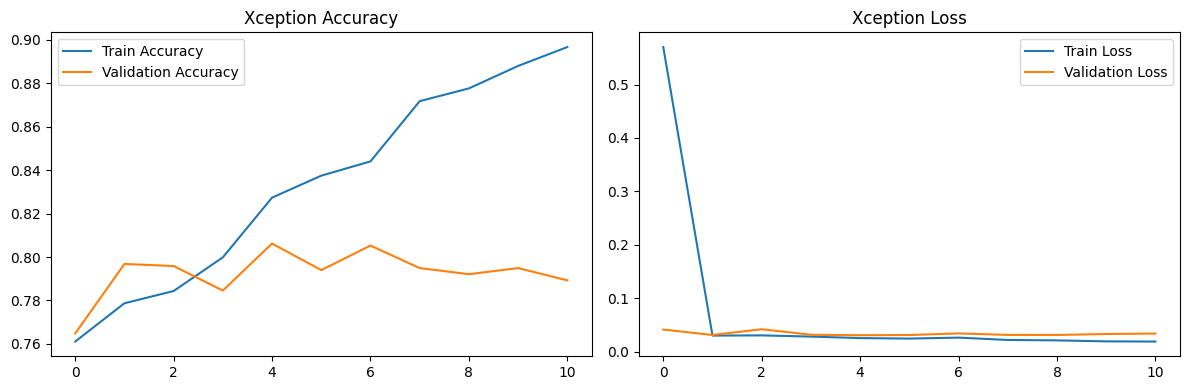

Xception - Test Accuracy: 79.54%, Test Loss: 0.0296

Training MobileNetV2...
Found 4257 images belonging to 2 classes.
Found 1063 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.
Data counts: Train=4257, Val=1063, Test=1784
Steps per epoch: 134, Validation steps: 34
Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.7065 - loss: 1.9977
Epoch 1: val_loss improved from inf to 0.09908, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/MobileNetV2_weights-001-0.0991.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7067 - loss: 1.9896 - val_accuracy: 0.7648 - val_loss: 0.0991 - learning_rate: 0.0010
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7614 - loss: 0.0407
Epoch 2: val_loss improved from 0.09908 to 0.09099, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/MobileNetV2_weights-002-0.0910.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accur

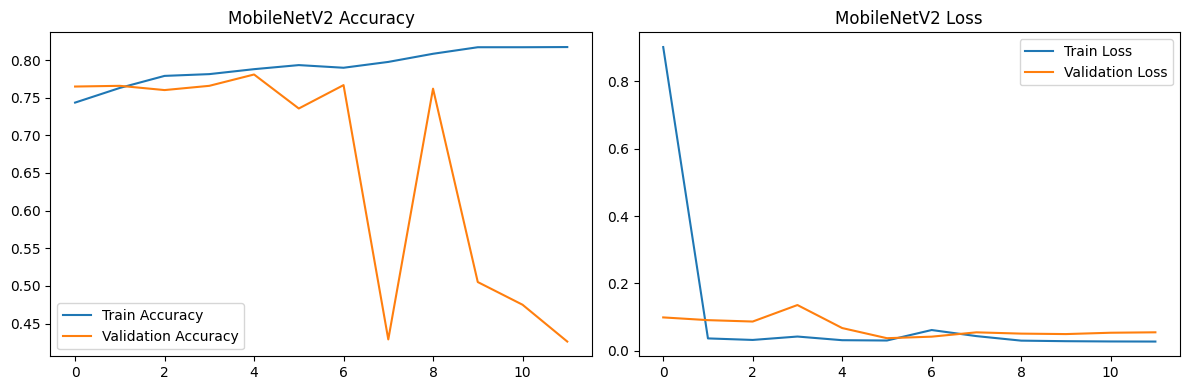

MobileNetV2 - Test Accuracy: 75.90%, Test Loss: 0.0343


In [ ]:
# Training with Loss Curves
trained_models = []
model_predictions = []
model_performances = []
model_histories = []

print("Training individual models...")
for i, config in enumerate(model_configs):
    print(f"\nTraining {config['name']}...")

    # Create data generators with proper split
    trainGen, validationGen, testGen, train_count, val_count = create_generators(
        config['preprocess_func'],
        config['target_size']
    )

    # Calculate steps per epoch
    steps_per_epoch = train_count // BATCH_SIZE
    validation_steps = val_count // BATCH_SIZE

    # For last partial batch
    if train_count % BATCH_SIZE != 0:
        steps_per_epoch += 1
    if val_count % BATCH_SIZE != 0:
        validation_steps += 1

    print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

    model = config['create_func'](config['input_shape'], classes=2)

    # Use Focal Loss
    opt = Adam(learning_rate=INIT_LR, weight_decay=0.0001)
    model.compile(loss=focal_loss(gamma=2.0, alpha=0.25), optimizer=opt, metrics=["accuracy"])

    os.makedirs("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models", exist_ok=True)
    MCName = os.path.sep.join(["/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models",
                               f"{config['name']}_weights-{{epoch:03d}}-{{val_loss:.4f}}.keras"])

    # Callbacks
    checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
    # Modified TensorBoard log directory to Google Drive
    tensorboard = TensorBoard(log_dir=f'/content/drive/MyDrive/NIH_processed/tensorboard_logs/{config["name"]}', histogram_freq=1)

    callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

    start_time = time.time()
    history = model.fit(
        x=trainGen,
        steps_per_epoch=steps_per_epoch,
        validation_data=validationGen,
        validation_steps=validation_steps,
        class_weight=classWeight,
        callbacks=callbacks,
        epochs=EPOCHS,
        verbose=1)

    training_time = (time.time() - start_time) / 60
    print(f"{config['name']} training completed in {training_time:.2f} minutes")
    model_histories.append(history)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{config["name"]} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{config["name"]} Loss')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"/content/drive/MyDrive/chest_xray/{config['name']}_training_history.png")
    plt.show()

    # Evaluate model
    test_results = model.evaluate(testGen, verbose=0)
    print(f"{config['name']} - Test Accuracy: {test_results[1]*100:.2f}%, Test Loss: {test_results[0]:.4f}")

    # Get predictions for ensemble
    testGen.reset()  # Reset generator for consistent ordering
    predIdxs = model.predict(testGen, verbose=0)

    trained_models.append(model)
    model_predictions.append(predIdxs)
    model_performances.append(test_results[1])

    tf.keras.backend.clear_session()

### **Load Saved Individual Model Weights**

In [ ]:
# Load Saved Individual Model Weights

print("Loading saved individual model weights...")

loaded_trained_models = []

if 'model_configs' in locals():
    for config in model_configs:
        model_name = config['name']
        print(f"Attempting to load weights for {model_name}...")

        # ensemble_models_dir
        ensemble_models_dir = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models"
        saved_weights_files = [f for f in os.listdir(ensemble_models_dir) if f.startswith(model_name) and f.endswith('.keras')]

        if saved_weights_files:
            # Sort files by modification time (latest is best)
            saved_weights_files.sort(key=lambda x: os.path.getmtime(os.path.join(ensemble_models_dir, x)))
            best_weights_filename = saved_weights_files[-1]
            best_weights_path = os.path.join(ensemble_models_dir, best_weights_filename)
            print(f"Found latest weights at: {best_weights_path}")

            try:
                model = config['create_func'](config['input_shape'], classes=2)
                model.load_weights(best_weights_path)
                loaded_trained_models.append(model)
                print(f"Loaded weights for {model_name}.")
            except Exception as e:
                print(f"Error loading weights for {model_name} from {best_weights_path}: {e}")
                loaded_trained_models.append(None)
        else:
            print(f"No saved weights found for {model_name}.")
            loaded_trained_models.append(None)

    trained_models = loaded_trained_models
    print("\nIndividual model weights loading process completed.")
    print(f"Number of models loaded successfully: {len([m for m in trained_models if m is not None])}/{len(model_configs)}")

else:
    print("'model_configs' not found. Please run Cell E first.")

Loading saved individual model weights...
Attempting to load weights for ResNet50...
Found latest weights at: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/ResNet50_weights-013-0.0317.keras
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Loaded weights for ResNet50.
Attempting to load weights for DenseNet121...
Found latest weights at: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/DenseNet121_weights-012-0.0324.keras
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded weights for DenseNet121.
Attempting to load weights for InceptionV3...
Found latest weights at: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/InceptionV3_weights-006-0.0320.keras
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded weights for InceptionV3.
Attempting to load weights for Xception...
Found latest weights at: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/Xception_weights-005-0.0313.keras
83683744/83683744 ━━

### **Neural Meta-Learner Implementation**

In [ ]:
# Neural Meta-Learner Implementation
print("\nBuilding Neural Meta-Learner for ensemble weighting...")

# Ensure validationGen is available. If not, run the cell that creates data generators.
if 'validationGen' not in locals():
    print("Error: 'validationGen' not found. Please run the cell that creates the data generators before running this cell.")
else:
    # Prepare meta-learner training data from validation set
    meta_features = []
    meta_labels = []

    # Use validation set to train meta-learner
    # Check if trained_models and model_configs are available
    if 'trained_models' in locals() and trained_models and 'model_configs' in locals():
        for batch_data, batch_labels in validationGen:
            if len(meta_labels) >= 1000:  # Limit to 1000 samples for faster processing
                break

            batch_predictions = []
            for j, model in enumerate(trained_models):
                if model is not None: # Only predict if model was loaded successfully
                    config = model_configs[j]
                    # Ensure target_size and preprocess_func are available in config
                    if 'target_size' in config and 'preprocess_func' in config:
                         resized_batch = tf.image.resize(batch_data, config['target_size'])
                         resized_batch = config['preprocess_func'](resized_batch)
                         pred = model.predict(resized_batch, verbose=0)
                         batch_predictions.append(pred)
                    else:
                         print(f"Warning: Config for {config.get('name', 'model')} is missing target_size or preprocess_func.")
                         # Append zero predictions or handle as appropriate
                         batch_predictions.append(np.zeros((batch_data.shape[0], 2))) # 2 classes
                else:
                     # Append zero predictions for models that failed to load
                     batch_predictions.append(np.zeros((batch_data.shape[0], 2))) #  2 classes


            # Stack predictions from all models (only if we got predictions for all models)
            if len(batch_predictions) == len(trained_models) and all(p is not None for p in batch_predictions):
                 stacked_preds = np.stack(batch_predictions, axis=1)
                 meta_features.append(stacked_preds)
                 meta_labels.append(batch_labels)
            else:
                 print("Warning: Skipping batch due to missing predictions from one or more models.")


        # Convert lists to numpy arrays if data was collected
        if meta_features:
            meta_features = np.vstack(meta_features)
            meta_labels = np.vstack(meta_labels)
            print(f"Prepared meta-learner training data with shape: features={meta_features.shape}, labels={meta_labels.shape}")

            # Build neural meta-learner
            from tensorflow.keras.layers import Flatten
            input_layer = Input(shape=(len(trained_models), 2))
            x = Flatten()(input_layer)
            x = Dense(128, activation='relu')(x)
            x = Dropout(0.3)(x)
            x = Dense(64, activation='relu')(x)
            x = Dropout(0.3)(x)
            output_layer = Dense(2, activation='softmax')(x)

            meta_model = Model(inputs=input_layer, outputs=output_layer)
            meta_model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

            # Train meta-learner
            print("\nTraining meta-learner...")
            meta_model.fit(
                meta_features,
                meta_labels,
                epochs=15,
                batch_size=32,
                validation_split=0.2,
                verbose=1
            )

            # Save the trained meta-learner model
            meta_model_save_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras"
            meta_model.save(meta_model_save_path)
            print(f"\nMeta-learner model saved to: {meta_model_save_path}")
        else:
            print("No data collected for meta-learner training. Please check data generators and model loading.")

    else:
        print("Error: 'trained_models' or 'model_configs' not found. Cannot prepare meta-learner training data.")


Building Neural Meta-Learner for ensemble weighting...


Prepared meta-learner training data with shape: features=(31275, 5, 2), labels=(31275, 2)

Training meta-learner...
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7628 - loss: 0.5171 - val_accuracy: 0.7909 - val_loss: 0.4750
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7844 - loss: 0.4820 - val_accuracy: 0.7909 - val_loss: 0.4739
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7869 - loss: 0.4800 - val_accuracy: 0.7915 - val_loss: 0.4728
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7897 - loss: 0.4773 - val_accuracy: 0.7923 - val_loss: 0.4718
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7898 - loss: 0.4753 - val_accuracy: 0.7931 - val_loss: 0.4706
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7915 - loss: 0.4742 - val_accuracy: 0.7930 - val_loss: 0.4707
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7938 - loss: 0.4754 - val_accuracy: 0.7936 - val_l

### **Optuna Optimisation for Final Ensemble Weighting**

In [ ]:
# Optuna Hyperparameter Optimisation for Final Ensemble
from functools import partial
import optuna
from sklearn.metrics import confusion_matrix, accuracy_score

print("\nRunning Optuna optimization for final ensemble weighting...")

# Create optimisation dataset
opt_samples = 0
target_opt_samples = 400
optimization_features = []
optimization_labels = []

# Use a balanced subset of the test set for optimization
balanced_testGen = ImageDataGenerator(
    preprocessing_function=model_configs[0]['preprocess_func']
).flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)

for batch_data, batch_labels in balanced_testGen:
    if opt_samples >= target_opt_samples:
        break

    batch_predictions = []
    for j, model in enumerate(trained_models):
        config = model_configs[j]
        resized_batch = tf.image.resize(batch_data, config['target_size'])
        resized_batch = config['preprocess_func'](resized_batch)
        pred = model.predict(resized_batch, verbose=0)
        batch_predictions.append(pred)

    stacked_preds = np.stack(batch_predictions, axis=1)
    optimization_features.append(stacked_preds)
    optimization_labels.append(batch_labels)
    opt_samples += len(batch_data)

optimization_features = np.vstack(optimization_features)
optimization_labels = np.vstack(optimization_labels)

# Enhanced Optuna objective function with class balance consideration
def objective(trial, features, labels):
    # Suggest weights for each model
    weights = []
    for i in range(len(trained_models)):
        weights.append(trial.suggest_float(f'weight_{i}', 0, 1))

    # Normalise weights
    weights = np.array(weights)
    weights /= weights.sum()

    # Calculate weighted ensemble predictions
    weighted_preds = np.zeros_like(features[:, 0, :])
    for i in range(len(trained_models)):
        weighted_preds += weights[i] * features[:, i, :]

    # Calculate accuracy with class balance consideration
    pred_labels = np.argmax(weighted_preds, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Calculate balanced accuracy instead of regular accuracy
    cm = confusion_matrix(true_labels, pred_labels)
    if cm.shape[0] > 1:  # Ensure we have both classes
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2
    else:
        balanced_accuracy = accuracy_score(true_labels, pred_labels)

    return balanced_accuracy

# Optimize with Optuna
study = optuna.create_study(direction='maximize')
objective_partial = partial(objective, features=optimization_features, labels=optimization_labels)
study.optimize(objective_partial, n_trials=100, timeout=3600)

# Get optimal weights
optimal_weights = [study.best_params[f'weight_{i}'] for i in range(len(trained_models))]
optimal_weights = np.array(optimal_weights)
optimal_weights /= optimal_weights.sum()

print("Optimal weights from Optuna:")
for i, (config, weight) in enumerate(zip(model_configs, optimal_weights)):
    print(f"{config['name']}: {weight:.4f}")

# Save the optimal weights
optimal_weights_save_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy"
np.save(optimal_weights_save_path, optimal_weights)
print(f"\nOptimal weights saved to: {optimal_weights_save_path}")


Running Optuna optimization for final ensemble weighting...
Found 1784 images belonging to 2 classes.


[I 2025-08-20 17:34:28,233] A new study created in memory with name: no-name-dda517e5-69cd-45c6-b460-0508030c38ad
[I 2025-08-20 17:34:28,238] Trial 0 finished with value: 0.6767871082859374 and parameters: {'weight_0': 0.7624961147183805, 'weight_1': 0.7582488109599314, 'weight_2': 0.9780027873720495, 'weight_3': 0.3513421584690445, 'weight_4': 0.2721465952266766}. Best is trial 0 with value: 0.6767871082859374.
[I 2025-08-20 17:34:28,241] Trial 1 finished with value: 0.6935708709713393 and parameters: {'weight_0': 0.9238703732339872, 'weight_1': 0.2360134202442984, 'weight_2': 0.7665614381367565, 'weight_3': 0.9524973283505378, 'weight_4': 0.09717309582851852}. Best is trial 1 with value: 0.6935708709713393.
[I 2025-08-20 17:34:28,243] Trial 2 finished with value: 0.6774841083974573 and parameters: {'weight_0': 0.28118930269729236, 'weight_1': 0.5629327950787335, 'weight_2': 0.7553352930518008, 'weight_3': 0.4198608689997446, 'weight_4': 0.6524850041450042}. Best is trial 1 with value

Optimal weights from Optuna:
ResNet50: 0.5354
DenseNet121: 0.0163
InceptionV3: 0.0587
Xception: 0.3728
MobileNetV2: 0.0168

Optimal weights saved to: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy


## **Evaluation**

In [ ]:
## Please run this before you evaluate.
optimal_weights_save_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy"
meta_model_save_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras"


### **Evaluation of Nuclear Ensemble**


Evaluating final ensemble with meta-learning...
Meta-learner model loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras
Optimal weights loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy
Found 1784 images belonging to 2 classes.
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Nuclear Ensemble Results:
Test Accuracy: 78.70%
Test Loss: 0.4642
AUC Score: 0.8529

Classification Report:
              precision    recall  f1-score   support

           0     0.7934    0.9481    0.8639      1272
           1     0.7500    0.3867    0.5103       512

    accuracy                         0.7870      1784
   macro avg     0.7717    0.6674    0.6871      1784
weighted avg     0.7810    0.7870    0.7624      1784


Confusion Matrix:
[[1206   66]
 [ 314  198]]
Accuracy: 0.7870
Sensitivity: 0.3867
Specificity: 0.9481


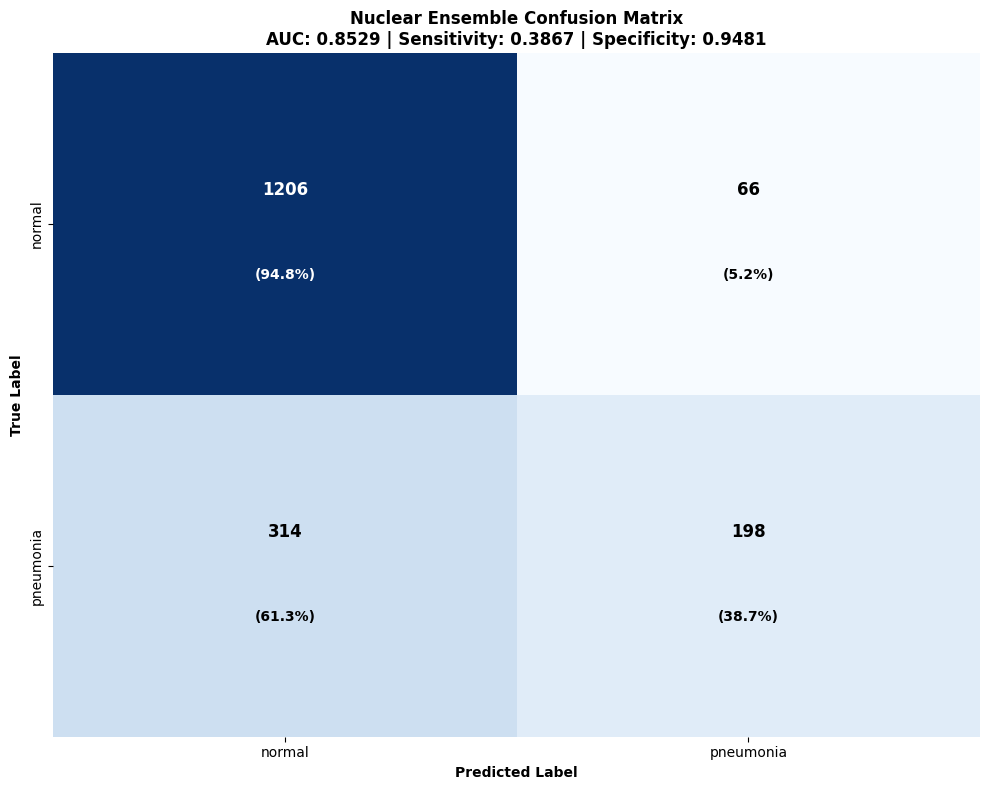

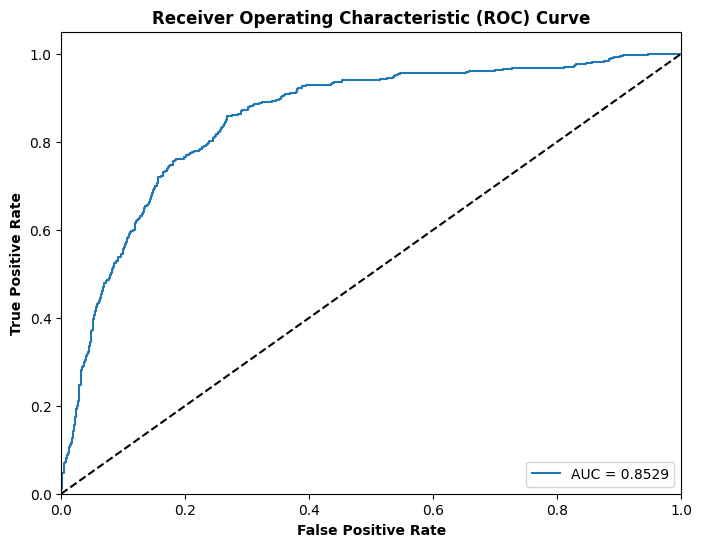


Nuclear Ensemble Final Performance:
Accuracy: 78.70%
Test Loss: 0.4642
AUC Score: 0.8529
Sensitivity: 0.3867
Specificity: 0.9481
Meta-learner model saved.
Optimal weights saved.


In [ ]:
# Section J: Final Evaluation with Meta-Learning (corrected with 60/40 blending)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

print("\nEvaluating final ensemble with meta-learning...")

# Load meta model and weights
meta_model = None
optimal_weights = None
try:
    meta_model = tf.keras.models.load_model(meta_model_save_path)
    print(f"Meta-learner model loaded from: {meta_model_save_path}")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")

try:
    optimal_weights = np.load(optimal_weights_save_path)
    print(f"Optimal weights loaded from: {optimal_weights_save_path}")
except Exception as e:
    print(f"Error loading optimal weights: {e}")

# Raw test generator (no preprocessing)
raw_test_gen = ImageDataGenerator().flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),  # Use a standard size, will resize for each model
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

all_meta_features = []
all_test_predictions = []
true_labels = []

test_count = raw_test_gen.samples
steps_test = test_count // BATCH_SIZE + (1 if test_count % BATCH_SIZE != 0 else 0)
raw_test_gen.reset()

batch_counter = 0
for batch_data, batch_labels in raw_test_gen:
    if batch_counter >= steps_test:
        break

    true_labels.extend(np.argmax(batch_labels, axis=1))

    batch_meta_features = []
    batch_model_predictions = []

    for j, model in enumerate(trained_models):
        cfg = model_configs[j]
        resized = tf.image.resize(batch_data, cfg['target_size'])
        resized = tf.cast(resized, tf.float32)
        pre = cfg['preprocess_func'](resized)
        pred = model.predict(pre, verbose=0)

        batch_meta_features.append(pred)
        batch_model_predictions.append(pred)

    if batch_meta_features:
        stacked_preds = np.stack(batch_meta_features, axis=1)
        all_meta_features.append(stacked_preds)

        weighted_pred = np.zeros_like(batch_model_predictions[0])
        for j, pred in enumerate(batch_model_predictions):
            w = optimal_weights[j] if (optimal_weights is not None and j < len(optimal_weights)) else (1.0/len(trained_models))
            weighted_pred += w * pred
        all_test_predictions.append(weighted_pred)

    batch_counter += 1

if all_meta_features:
    all_meta_features = np.vstack(all_meta_features)
    all_test_predictions = np.vstack(all_test_predictions)
    true_labels = np.array(true_labels)

    # Get predictions from meta-learner
    meta_predictions = meta_model.predict(all_meta_features)

    # Apply 60/40 blending: 60% meta-learner, 40% weighted ensemble
    final_predictions = 0.6 * meta_predictions + 0.4 * all_test_predictions
    predicted_labels = np.argmax(final_predictions, axis=1)

    final_accuracy = np.mean(predicted_labels == true_labels)
    # Calculate test loss
    test_loss = tf.keras.losses.sparse_categorical_crossentropy(true_labels, final_predictions)
    test_loss = np.mean(test_loss)

    if len(np.unique(true_labels)) > 1:
        auc_score = roc_auc_score(true_labels, final_predictions[:, 1])
    else:
        auc_score = "N/A"

    print(f"\nNuclear Ensemble Results:")
    print(f"Test Accuracy: {final_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"AUC Score: {auc_score if isinstance(auc_score, str) else f'{auc_score:.4f}'}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, digits=4))

    cm = confusion_matrix(true_labels, predicted_labels)
    total = cm.sum()
    acc = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Confusion plot with enhanced annotations
    plt.figure(figsize=(10, 8))
    class_names = labels if 'labels' in locals() else ['0', '1']

    # Create heatmap without annotations first
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add custom annotations with bold text and specific colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            row_sum = cm[i, :].sum()
            percentage = count / row_sum * 100 if row_sum > 0 else 0.0

            # Determine text color: white only for True Negative (top-left cell), black for all others
            text_color = 'white' if (i == 0 and j == 0) else 'black'

            # Add count (bold) - positioned slightly higher
            ax.text(j + 0.5, i + 0.4, f'{count}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=12,
                   fontweight='bold')

            # Add percentage (bold) - positioned slightly lower with a small gap
            ax.text(j + 0.5, i + 0.65, f'({percentage:.1f}%)',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=10,
                   fontweight='bold')

    # Create title without accuracy and make it bold
    title_parts = []
    if isinstance(auc_score, float):
        title_parts.append(f"AUC: {auc_score:.4f}")
    title_parts.append(f"Sensitivity: {sensitivity:.4f}")
    title_parts.append(f"Specificity: {specificity:.4f}")

    title_text = "Nuclear Ensemble Confusion Matrix\n" + " | ".join(title_parts)

    plt.title(title_text, fontweight='bold')
    plt.xlabel("Predicted Label", fontweight='bold')
    plt.ylabel("True Label", fontweight='bold')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_confusion_matrix.png")
    plt.show()

    if isinstance(auc_score, float):
        fpr, tpr, thresholds = roc_curve(true_labels, final_predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontweight='bold')
        plt.ylabel('True Positive Rate', fontweight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
        plt.legend(loc="lower right")
        plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_roc_curve.png")
        plt.show()

    print("\nNuclear Ensemble Final Performance:")
    print(f"Accuracy: {final_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    if isinstance(auc_score, float):
        print(f"AUC Score: {auc_score:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Save meta-learner and optimal weights
    if meta_model is not None:
        meta_model.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras")
        print("Meta-learner model saved.")

    if optimal_weights is not None:
        np.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy", optimal_weights)
        print("Optimal weights saved.")
else:
    print("No batches processed for evaluation.")

#### **Testing Nuclear Ensemble Evaluation with Optimal Threshold**


Evaluating final ensemble with meta-learning...
Meta-learner model loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras
Optimal weights loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy
Found 1784 images belonging to 2 classes.


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Nuclear Ensemble Results:
Test Accuracy: 76.74%
AUC Score: 0.8529

Classification Report:
              precision    recall  f1-score   support

           0     0.9281    0.7303    0.8174      1272
           1     0.5619    0.8594    0.6795       512

    accuracy                         0.7674      1784
   macro avg     0.7450    0.7949    0.7485      1784
weighted avg     0.8230    0.7674    0.7778      1784


Confusion Matrix:
[[929 343]
 [ 72 440]]
Accuracy: 0.7674
Sensitivity: 0.8594
Specificity: 0.7303


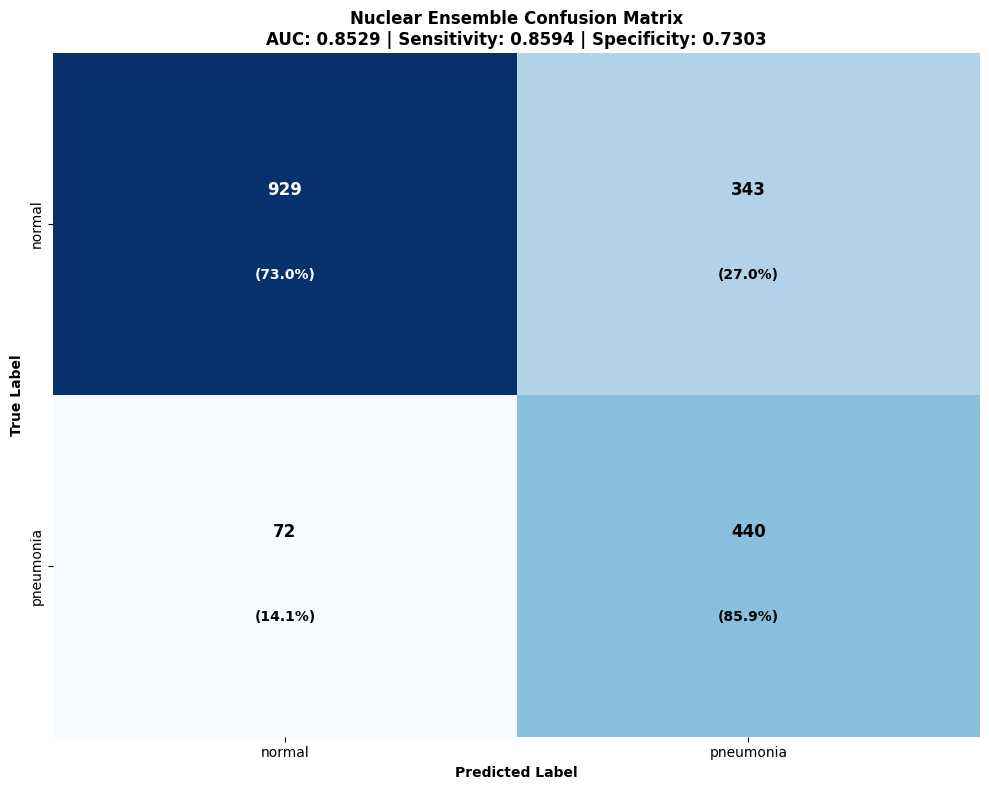

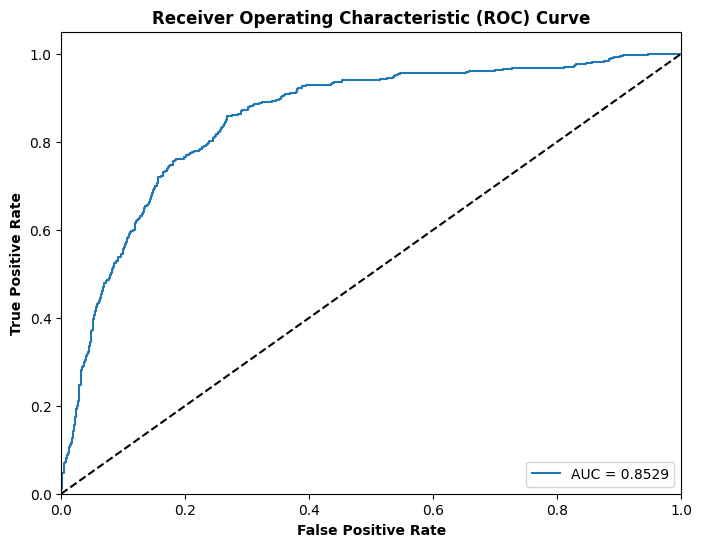


Nuclear Ensemble Final Performance:
Accuracy: 76.74%
AUC Score: 0.8529
Sensitivity: 0.8594
Specificity: 0.7303
Meta-learner model saved.
Optimal weights saved.


In [ ]:
#######
# Section J: Final Evaluation with Meta-Learning (with Optimal Threshold)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

print("\nEvaluating final ensemble with meta-learning...")

# Load meta model and weights
meta_model = None
optimal_weights = None
try:
    meta_model = tf.keras.models.load_model(meta_model_save_path)
    print(f"Meta-learner model loaded from: {meta_model_save_path}")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")

try:
    optimal_weights = np.load(optimal_weights_save_path)
    print(f"Optimal weights loaded from: {optimal_weights_save_path}")
except Exception as e:
    print(f"Error loading optimal weights: {e}")

# Raw test generator (no preprocessing)
raw_test_gen = ImageDataGenerator().flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),  # Use a standard size, will resize for each model
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

all_meta_features = []
all_test_predictions = []
true_labels = []

test_count = raw_test_gen.samples
steps_test = test_count // BATCH_SIZE + (1 if test_count % BATCH_SIZE != 0 else 0)
raw_test_gen.reset()

batch_counter = 0
for batch_data, batch_labels in raw_test_gen:
    if batch_counter >= steps_test:
        break

    true_labels.extend(np.argmax(batch_labels, axis=1))

    batch_meta_features = []
    batch_model_predictions = []

    for j, model in enumerate(trained_models):
        cfg = model_configs[j]
        resized = tf.image.resize(batch_data, cfg['target_size'])
        resized = tf.cast(resized, tf.float32)
        pre = cfg['preprocess_func'](resized)
        pred = model.predict(pre, verbose=0)

        batch_meta_features.append(pred)
        batch_model_predictions.append(pred)

    if batch_meta_features:
        stacked_preds = np.stack(batch_meta_features, axis=1)
        all_meta_features.append(stacked_preds)

        weighted_pred = np.zeros_like(batch_model_predictions[0])
        for j, pred in enumerate(batch_model_predictions):
            w = optimal_weights[j] if (optimal_weights is not None and j < len(optimal_weights)) else (1.0/len(trained_models))
            weighted_pred += w * pred
        all_test_predictions.append(weighted_pred)

    batch_counter += 1

if all_meta_features:
    all_meta_features = np.vstack(all_meta_features)
    all_test_predictions = np.vstack(all_test_predictions)
    true_labels = np.array(true_labels)

    # Get predictions from meta-learner
    meta_predictions = meta_model.predict(all_meta_features)

    # Apply 60/40 blending: 60% meta-learner, 40% weighted ensemble
    final_predictions = 0.6 * meta_predictions + 0.4 * all_test_predictions

    # Calculate optimal threshold using Youden's J statistic
    if len(np.unique(true_labels)) > 1:
        fpr, tpr, thresholds = roc_curve(true_labels, final_predictions[:, 1])
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        # Apply optimal threshold
        binary_predictions = (final_predictions[:, 1] >= optimal_threshold).astype(int)
        predicted_labels = binary_predictions
    else:
        # Fallback to argmax if only one class
        predicted_labels = np.argmax(final_predictions, axis=1)
        optimal_threshold = 0.5

    final_accuracy = np.mean(predicted_labels == true_labels)
    if len(np.unique(true_labels)) > 1:
        auc_score = roc_auc_score(true_labels, final_predictions[:, 1])
    else:
        auc_score = "N/A"

    print(f"\nNuclear Ensemble Results:")
    print(f"Test Accuracy: {final_accuracy*100:.2f}%")
    print(f"AUC Score: {auc_score if isinstance(auc_score, str) else f'{auc_score:.4f}'}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, digits=4))

    cm = confusion_matrix(true_labels, predicted_labels)
    total = cm.sum()
    acc = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Confusion plot with enhanced annotations
    plt.figure(figsize=(10, 8))
    class_names = labels if 'labels' in locals() else ['0', '1']

    # Create heatmap without annotations first
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add custom annotations with bold text and specific colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            row_sum = cm[i, :].sum()
            percentage = count / row_sum * 100 if row_sum > 0 else 0.0

            # Determine text color: white only for True Negative (top-left cell), black for all others
            text_color = 'white' if (i == 0 and j == 0) else 'black'

            # Add count (bold) - positioned slightly higher
            ax.text(j + 0.5, i + 0.4, f'{count}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=12,
                   fontweight='bold')

            # Add percentage (bold) - positioned slightly lower with a small gap
            ax.text(j + 0.5, i + 0.65, f'({percentage:.1f}%)',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=10,
                   fontweight='bold')

    # Create title without accuracy and make it bold
    title_parts = []
    if isinstance(auc_score, float):
        title_parts.append(f"AUC: {auc_score:.4f}")
    title_parts.append(f"Sensitivity: {sensitivity:.4f}")
    title_parts.append(f"Specificity: {specificity:.4f}")

    title_text = "Nuclear Ensemble Confusion Matrix\n" + " | ".join(title_parts)

    plt.title(title_text, fontweight='bold')
    plt.xlabel("Predicted Label", fontweight='bold')
    plt.ylabel("True Label", fontweight='bold')
    plt.tight_layout()
    #plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_confusion_matrix.png")
    plt.show()

    if isinstance(auc_score, float):
        fpr, tpr, thresholds = roc_curve(true_labels, final_predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontweight='bold')
        plt.ylabel('True Positive Rate', fontweight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
        plt.legend(loc="lower right")
        plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_roc_curve.png")
        plt.show()

    print("\nNuclear Ensemble Final Performance:")
    print(f"Accuracy: {final_accuracy*100:.2f}%")
    if isinstance(auc_score, float):
        print(f"AUC Score: {auc_score:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Save meta-learner and optimal weights
    if meta_model is not None:
        meta_model.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras")
        print("Meta-learner model saved.")

    if optimal_weights is not None:
        np.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy", optimal_weights)
        print("Optimal weights saved.")
else:
    print("No batches processed for evaluation.")

In [ ]:
# Add this print statement right after the optimal threshold is calculated
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# # Place it right after this line in your code:
# optimal_threshold = thresholds[optimal_idx]

Optimal Threshold: 0.2120



Evaluating final ensemble with meta-learning...
Meta-learner model loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras
Optimal weights loaded from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy
Found 1784 images belonging to 2 classes.
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Nuclear Ensemble Results:
Test Accuracy: 76.74%
AUC Score: 0.8529

Classification Report:
              precision    recall  f1-score   support

           0     0.9281    0.7303    0.8174      1272
           1     0.5619    0.8594    0.6795       512

    accuracy                         0.7674      1784
   macro avg     0.7450    0.7949    0.7485      1784
weighted avg     0.8230    0.7674    0.7778      1784


Confusion Matrix:
[[929 343]
 [ 72 440]]
Accuracy: 0.7674
Sensitivity: 0.8594
Specificity: 0.7303


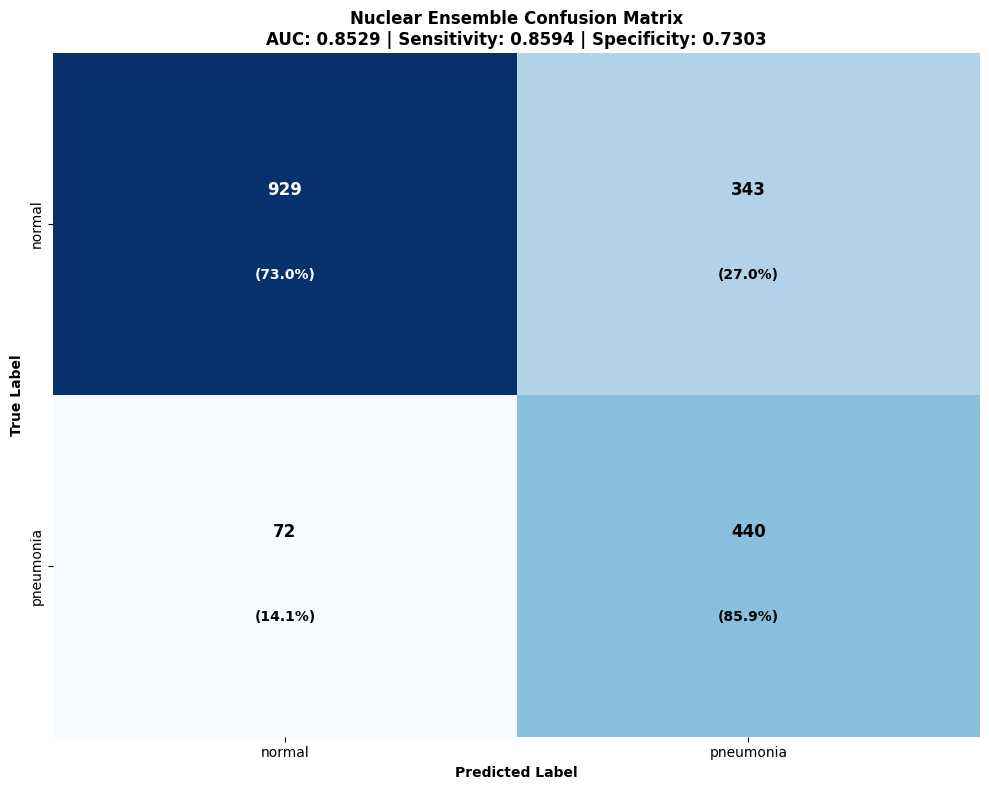

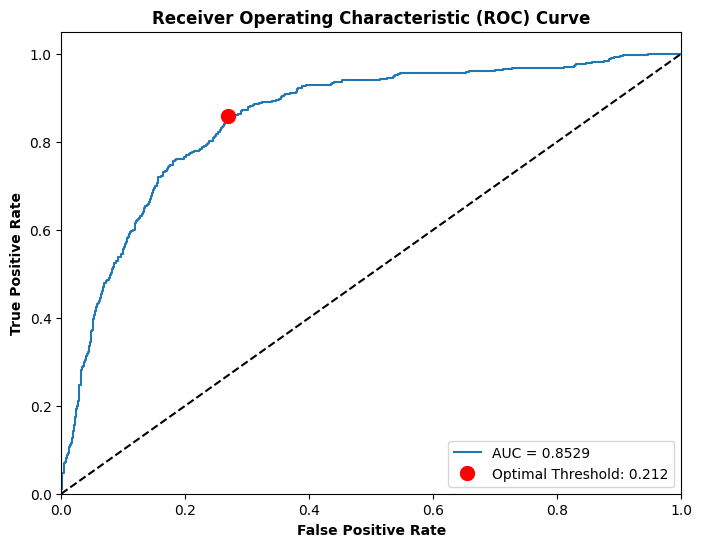


Nuclear Ensemble Final Performance:
Accuracy: 76.74%
AUC Score: 0.8529
Sensitivity: 0.8594
Specificity: 0.7303
Meta-learner model saved.
Optimal weights saved.


In [ ]:
# Section J: Final Evaluation with Meta-Learning (with Optimal Threshold)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

print("\nEvaluating final ensemble with meta-learning...")

# Load meta model and weights
meta_model = None
optimal_weights = None
try:
    meta_model = tf.keras.models.load_model(meta_model_save_path)
    print(f"Meta-learner model loaded from: {meta_model_save_path}")
except Exception as e:
    print(f"Error loading meta-learner model: {e}")

try:
    optimal_weights = np.load(optimal_weights_save_path)
    print(f"Optimal weights loaded from: {optimal_weights_save_path}")
except Exception as e:
    print(f"Error loading optimal weights: {e}")

# Raw test generator (no preprocessing)
raw_test_gen = ImageDataGenerator().flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),  # Use a standard size, will resize for each model
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

all_meta_features = []
all_test_predictions = []
true_labels = []

test_count = raw_test_gen.samples
steps_test = test_count // BATCH_SIZE + (1 if test_count % BATCH_SIZE != 0 else 0)
raw_test_gen.reset()

batch_counter = 0
for batch_data, batch_labels in raw_test_gen:
    if batch_counter >= steps_test:
        break

    true_labels.extend(np.argmax(batch_labels, axis=1))

    batch_meta_features = []
    batch_model_predictions = []

    for j, model in enumerate(trained_models):
        cfg = model_configs[j]
        resized = tf.image.resize(batch_data, cfg['target_size'])
        resized = tf.cast(resized, tf.float32)
        pre = cfg['preprocess_func'](resized)
        pred = model.predict(pre, verbose=0)

        batch_meta_features.append(pred)
        batch_model_predictions.append(pred)

    if batch_meta_features:
        stacked_preds = np.stack(batch_meta_features, axis=1)
        all_meta_features.append(stacked_preds)

        weighted_pred = np.zeros_like(batch_model_predictions[0])
        for j, pred in enumerate(batch_model_predictions):
            w = optimal_weights[j] if (optimal_weights is not None and j < len(optimal_weights)) else (1.0/len(trained_models))
            weighted_pred += w * pred
        all_test_predictions.append(weighted_pred)

    batch_counter += 1

if all_meta_features:
    all_meta_features = np.vstack(all_meta_features)
    all_test_predictions = np.vstack(all_test_predictions)
    true_labels = np.array(true_labels)

    # Get predictions from meta-learner
    meta_predictions = meta_model.predict(all_meta_features)

    # Apply 60/40 blending: 60% meta-learner, 40% weighted ensemble
    final_predictions = 0.6 * meta_predictions + 0.4 * all_test_predictions

    # Calculate optimal threshold using Youden's J statistic
    if len(np.unique(true_labels)) > 1:
        fpr, tpr, thresholds = roc_curve(true_labels, final_predictions[:, 1])
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        # Apply optimal threshold
        binary_predictions = (final_predictions[:, 1] >= optimal_threshold).astype(int)
        predicted_labels = binary_predictions
    else:
        # Fallback to argmax if only one class
        predicted_labels = np.argmax(final_predictions, axis=1)
        optimal_threshold = 0.5

    final_accuracy = np.mean(predicted_labels == true_labels)
    if len(np.unique(true_labels)) > 1:
        auc_score = roc_auc_score(true_labels, final_predictions[:, 1])
    else:
        auc_score = "N/A"

    print(f"\nNuclear Ensemble Results:")
    print(f"Test Accuracy: {final_accuracy*100:.2f}%")
    print(f"AUC Score: {auc_score if isinstance(auc_score, str) else f'{auc_score:.4f}'}")

    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, digits=4))

    cm = confusion_matrix(true_labels, predicted_labels)
    total = cm.sum()
    acc = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Confusion plot with enhanced annotations
    plt.figure(figsize=(10, 8))
    class_names = labels if 'labels' in locals() else ['0', '1']

    # Create heatmap without annotations first
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add custom annotations with bold text and specific colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            row_sum = cm[i, :].sum()
            percentage = count / row_sum * 100 if row_sum > 0 else 0.0

            # Determine text color: white only for True Negative (top-left cell), black for all others
            text_color = 'white' if (i == 0 and j == 0) else 'black'

            # Add count (bold) - positioned slightly higher
            ax.text(j + 0.5, i + 0.4, f'{count}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=12,
                   fontweight='bold')

            # Add percentage (bold) - positioned slightly lower with a small gap
            ax.text(j + 0.5, i + 0.65, f'({percentage:.1f}%)',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=10,
                   fontweight='bold')

    # Create title without accuracy and make it bold
    title_parts = []
    if isinstance(auc_score, float):
        title_parts.append(f"AUC: {auc_score:.4f}")
    title_parts.append(f"Sensitivity: {sensitivity:.4f}")
    title_parts.append(f"Specificity: {specificity:.4f}")

    title_text = "Nuclear Ensemble Confusion Matrix\n" + " | ".join(title_parts)

    plt.title(title_text, fontweight='bold')
    plt.xlabel("Predicted Label", fontweight='bold')
    plt.ylabel("True Label", fontweight='bold')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_confusion_matrix.png")
    plt.show()

    if isinstance(auc_score, float):
        fpr, tpr, thresholds = roc_curve(true_labels, final_predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')

        # Mark the optimal threshold point
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, label=f'Optimal Threshold: {optimal_threshold:.3f}')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontweight='bold')
        plt.ylabel('True Positive Rate', fontweight='bold')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
        plt.legend(loc="lower right")
        plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/nuclear_ensemble_roc_curve.png")
        plt.show()

    print("\nNuclear Ensemble Final Performance:")
    print(f"Accuracy: {final_accuracy*100:.2f}%")
    if isinstance(auc_score, float):
        print(f"AUC Score: {auc_score:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Save meta-learner and optimal weights
    if meta_model is not None:
        meta_model.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/meta_learner_model.keras")
        print("Meta-learner model saved.")

    if optimal_weights is not None:
        np.save("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/optimal_weights.npy", optimal_weights)
        print("Optimal weights saved.")
else:
    print("No batches processed for evaluation.")

#### **Individual Model Evaluation**


Evaluating individual models on test set...
Found 1784 images belonging to 2 classes.

Evaluating ResNet50...
ResNet50 Results:
Test Accuracy: 80.16%
Test Loss: 0.4751
AUC Score: 0.8535

Classification Report:
              precision    recall  f1-score   support

           0     0.8246    0.9167    0.8682      1272
           1     0.7135    0.5156    0.5986       512

    accuracy                         0.8016      1784
   macro avg     0.7691    0.7161    0.7334      1784
weighted avg     0.7927    0.8016    0.7908      1784


Confusion Matrix:
[[1166  106]
 [ 248  264]]
Accuracy: 0.8016
Sensitivity: 0.5156
Specificity: 0.9167


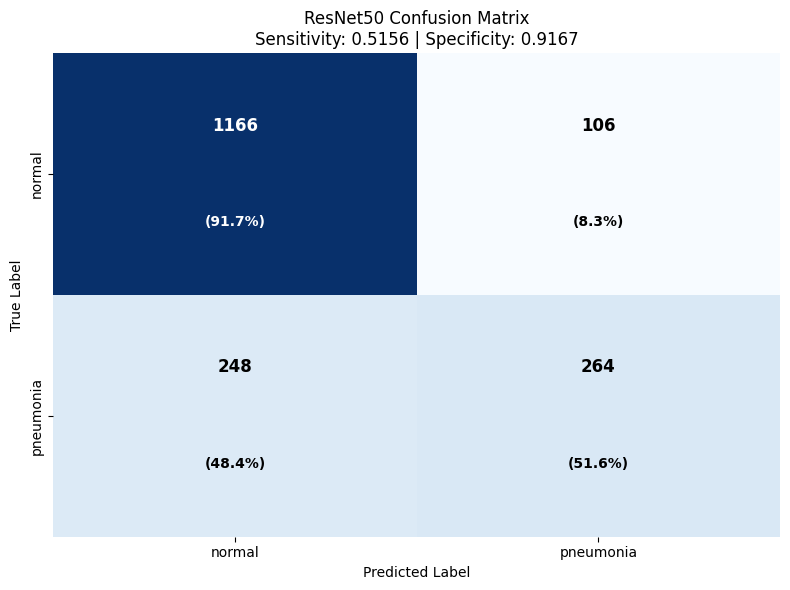

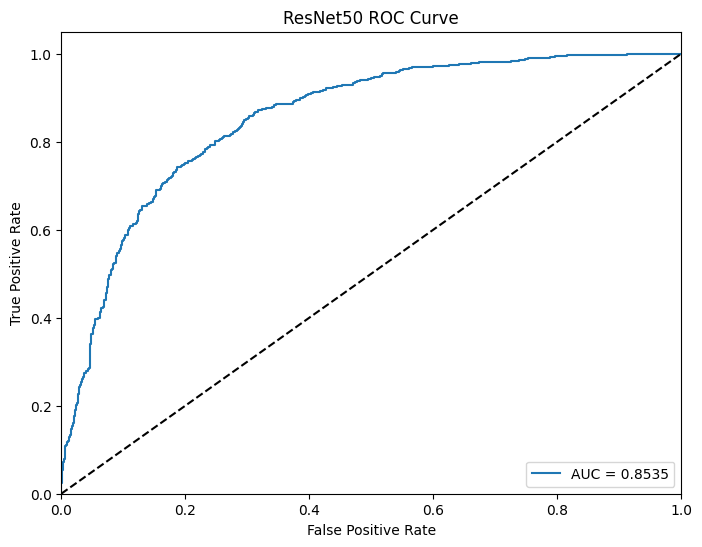


Evaluating DenseNet121...
DenseNet121 Results:
Test Accuracy: 78.20%
Test Loss: 0.5156
AUC Score: 0.8364

Classification Report:
              precision    recall  f1-score   support

           0     0.7993    0.9269    0.8584      1272
           1     0.6990    0.4219    0.5262       512

    accuracy                         0.7820      1784
   macro avg     0.7492    0.6744    0.6923      1784
weighted avg     0.7705    0.7820    0.7631      1784


Confusion Matrix:
[[1179   93]
 [ 296  216]]
Accuracy: 0.7820
Sensitivity: 0.4219
Specificity: 0.9269


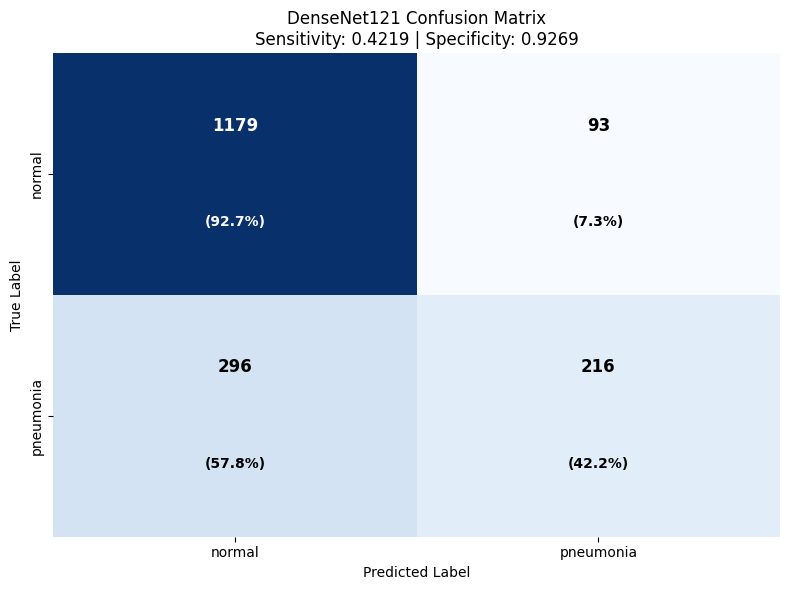

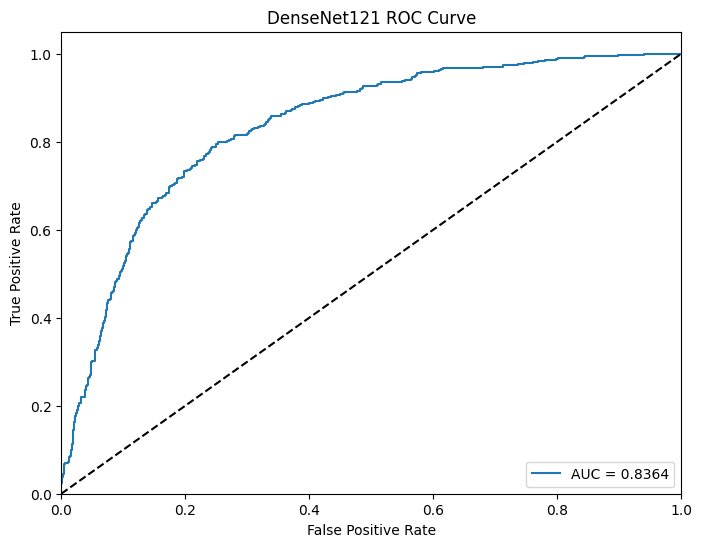


Evaluating InceptionV3...
InceptionV3 Results:
Test Accuracy: 76.91%
Test Loss: 0.5275
AUC Score: 0.8242

Classification Report:
              precision    recall  f1-score   support

           0     0.7792    0.9434    0.8535      1272
           1     0.7049    0.3359    0.4550       512

    accuracy                         0.7691      1784
   macro avg     0.7421    0.6397    0.6543      1784
weighted avg     0.7579    0.7691    0.7391      1784


Confusion Matrix:
[[1200   72]
 [ 340  172]]
Accuracy: 0.7691
Sensitivity: 0.3359
Specificity: 0.9434


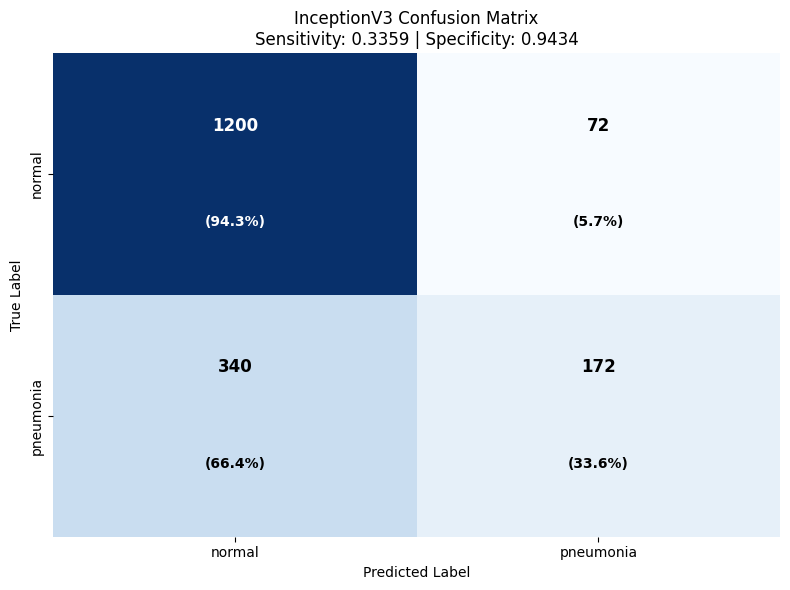

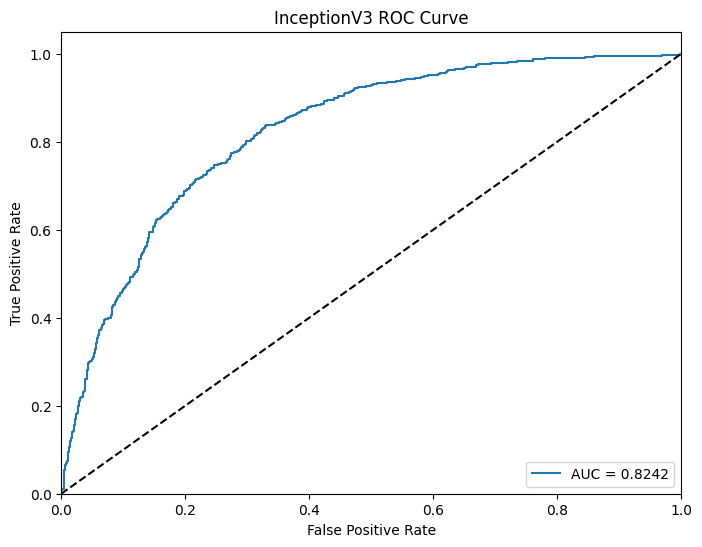


Evaluating Xception...
Xception Results:
Test Accuracy: 79.54%
Test Loss: 0.4946
AUC Score: 0.8436

Classification Report:
              precision    recall  f1-score   support

           0     0.8134    0.9253    0.8658      1272
           1     0.7181    0.4727    0.5701       512

    accuracy                         0.7954      1784
   macro avg     0.7658    0.6990    0.7179      1784
weighted avg     0.7861    0.7954    0.7809      1784


Confusion Matrix:
[[1177   95]
 [ 270  242]]
Accuracy: 0.7954
Sensitivity: 0.4727
Specificity: 0.9253


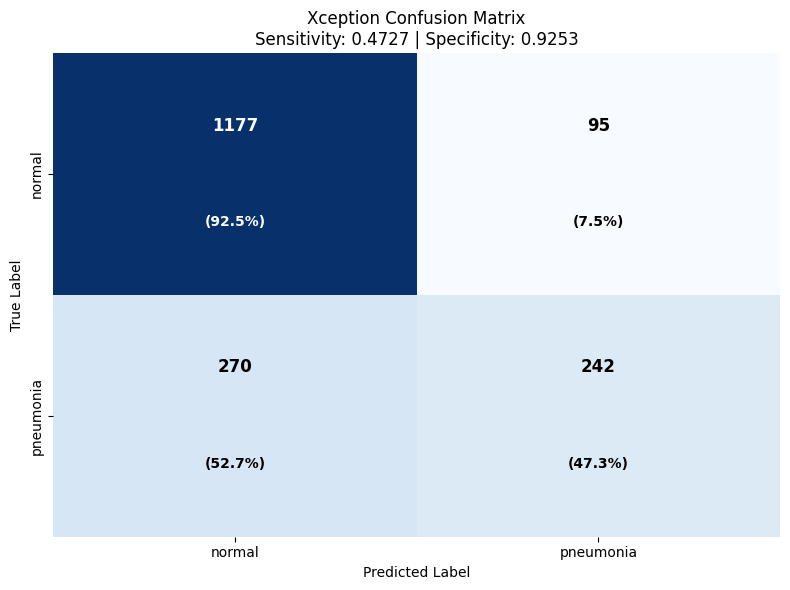

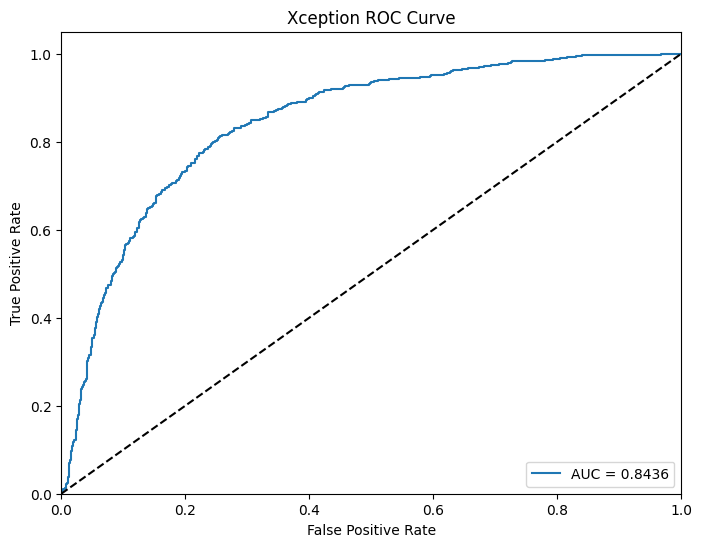


Evaluating MobileNetV2...
MobileNetV2 Results:
Test Accuracy: 74.72%
Test Loss: 0.5639
AUC Score: 0.7930

Classification Report:
              precision    recall  f1-score   support

           0     0.8585    0.7728    0.8134      1272
           1     0.5477    0.6836    0.6082       512

    accuracy                         0.7472      1784
   macro avg     0.7031    0.7282    0.7108      1784
weighted avg     0.7693    0.7472    0.7545      1784


Confusion Matrix:
[[983 289]
 [162 350]]
Accuracy: 0.7472
Sensitivity: 0.6836
Specificity: 0.7728


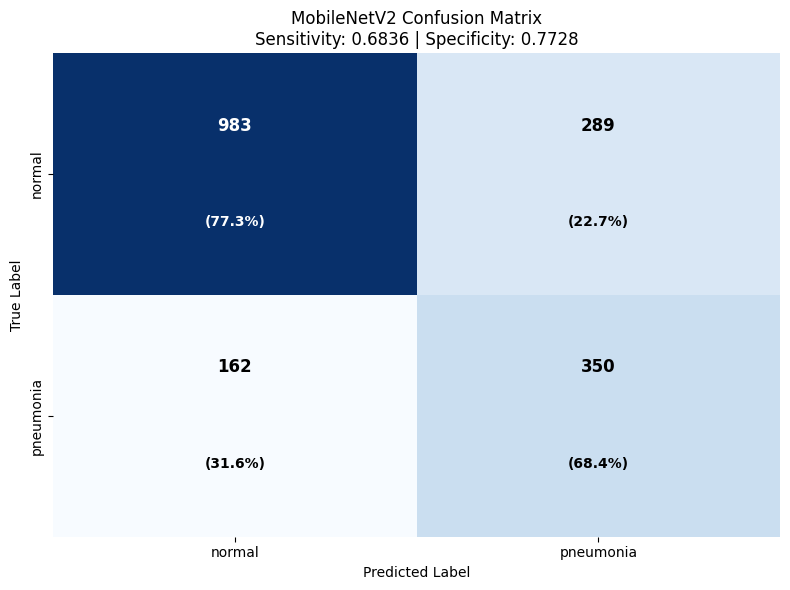

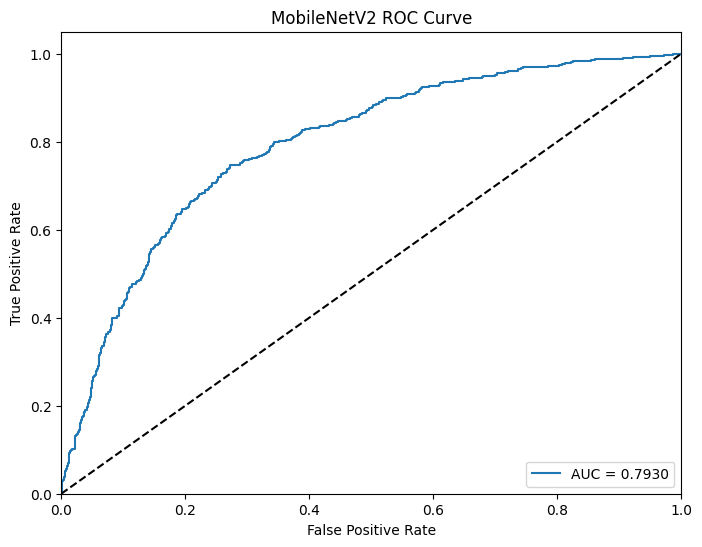


SUMMARY OF INDIVIDUAL MODEL PERFORMANCES

Performance Summary Table:
      Model Accuracy Test Loss    AUC Sensitivity Specificity
   ResNet50   80.16%    0.4751 0.8535      0.5156      0.9167
DenseNet121   78.20%    0.5156 0.8364      0.4219      0.9269
InceptionV3   76.91%    0.5275 0.8242      0.3359      0.9434
   Xception   79.54%    0.4946 0.8436      0.4727      0.9253
MobileNetV2   74.72%    0.5639 0.7930      0.6836      0.7728


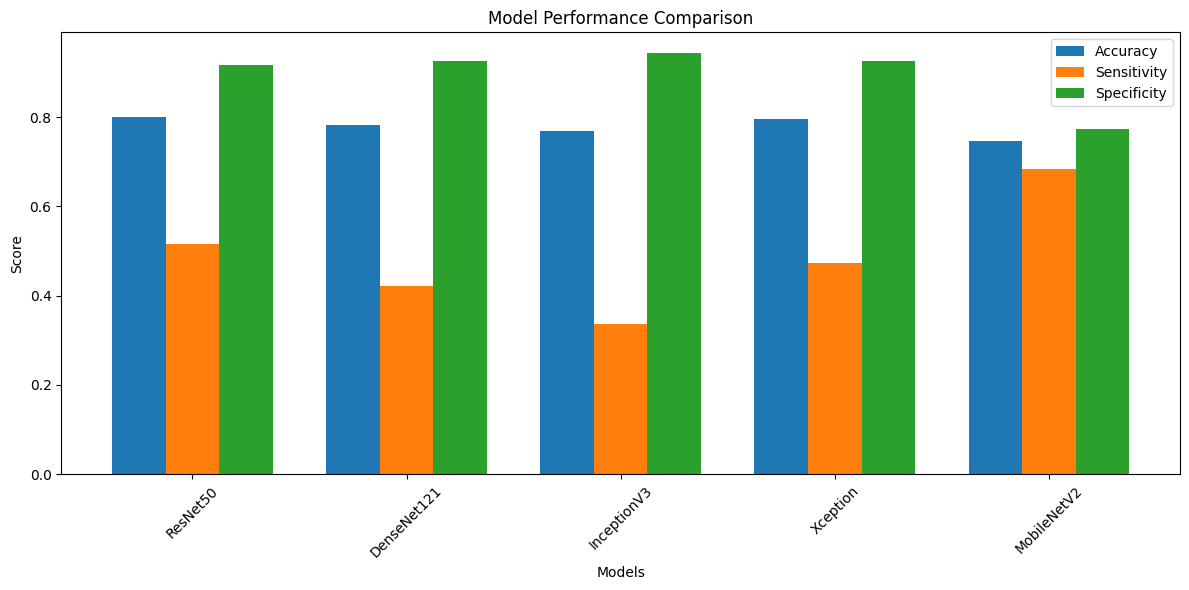


Individual model evaluation completed!


In [ ]:
# Individual Model Evaluation
print("\nEvaluating individual models on test set...")

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a raw test generator (no preprocessing)
raw_test_gen = ImageDataGenerator().flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),  # Use a standard size, will resize for each model
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate each model individually
model_performances = {}

for i, (model, config) in enumerate(zip(trained_models, model_configs)):
    if model is None:
        print(f"Skipping {config['name']} - model not loaded")
        continue

    print(f"\nEvaluating {config['name']}...")

    # Reset generator for each model
    raw_test_gen.reset()
    test_count = raw_test_gen.samples
    steps_test = test_count // BATCH_SIZE + (1 if test_count % BATCH_SIZE != 0 else 0)

    all_predictions = []
    true_labels = []

    batch_counter = 0
    for batch_data, batch_labels in raw_test_gen:
        if batch_counter >= steps_test:
            break

        true_labels.extend(np.argmax(batch_labels, axis=1))

        # Preprocess for this specific model
        resized = tf.image.resize(batch_data, config['target_size'])
        resized = tf.cast(resized, tf.float32)
        preprocessed = config['preprocess_func'](resized)

        # Predict
        pred = model.predict(preprocessed, verbose=0)
        all_predictions.append(pred)

        batch_counter += 1

    # Combine results
    all_predictions = np.vstack(all_predictions)
    true_labels = np.array(true_labels)

    predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    accuracy = np.mean(predicted_labels == true_labels)
    # Calculate test loss
    test_loss = tf.keras.losses.sparse_categorical_crossentropy(true_labels, all_predictions)
    test_loss = np.mean(test_loss)

    if len(np.unique(true_labels)) > 1:
        auc_score = roc_auc_score(true_labels, all_predictions[:, 1])
    else:
        auc_score = "N/A"

    # Classification report
    print(f"{config['name']} Results:")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"AUC Score: {auc_score if isinstance(auc_score, str) else f'{auc_score:.4f}'}")

    # Add classification report with 4 significant figures
    print("\nClassification Report:")
    cr = classification_report(true_labels, predicted_labels, digits=4)
    print(cr)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    total = cm.sum()
    acc = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Store performance for comparison
    model_performances[config['name']] = {
        'accuracy': accuracy,
        'test_loss': test_loss,
        'auc': auc_score if isinstance(auc_score, float) else 0,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    # Plot confusion matrix for each model with enhanced annotations
    plt.figure(figsize=(8, 6))
    class_names = labels if 'labels' in locals() else ['0', '1']

    # Create heatmap without annotations first
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add custom annotations with bold text and specific colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            row_sum = cm[i, :].sum()
            percentage = count / row_sum * 100 if row_sum > 0 else 0.0

            # Determine text color: white only for True Negative (top-left cell), black for all others
            text_color = 'white' if (i == 0 and j == 0) else 'black'

            # Add count (bold)
            ax.text(j + 0.5, i + 0.3, f'{count}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=12,
                   fontweight='bold')

            # Add percentage (bold)
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=10,
                   fontweight='bold')

    auc_text = f"AUC: {auc_score:.4f}" if isinstance(auc_score, float) else f"AUC: {auc_score}"
    plt.title(f"{config['name']} Confusion Matrix\nSensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/{config['name']}_confusion_matrix.png")
    plt.show()

    # Plot ROC curve if applicable
    if isinstance(auc_score, float):
        fpr, tpr, thresholds = roc_curve(true_labels, all_predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{config["name"]} ROC Curve')
        plt.legend(loc="lower right")
        plt.savefig(f"/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/{config['name']}_roc_curve.png")
        plt.show()

# Create a summary table of all model performances
print("\n" + "="*80)
print("SUMMARY OF INDIVIDUAL MODEL PERFORMANCES")
print("="*80)

# Prepare data for table
summary_data = []
for model_name, metrics in model_performances.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']*100:.2f}%",
        'Test Loss': f"{metrics['test_loss']:.4f}",
        'AUC': f"{metrics['auc']:.4f}" if metrics['auc'] > 0 else 'N/A',
        'Sensitivity': f"{metrics['sensitivity']:.4f}",
        'Specificity': f"{metrics['specificity']:.4f}"
    })

# Create and display DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nPerformance Summary Table:")
print(df_summary.to_string(index=False))

# Create a comparison plot
if model_performances:
    models = list(model_performances.keys())
    accuracies = [model_performances[m]['accuracy'] for m in models]
    sensitivities = [model_performances[m]['sensitivity'] for m in models]
    specificities = [model_performances[m]['specificity'] for m in models]

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, sensitivities, width, label='Sensitivity')
    plt.bar(x + width, specificities, width, label='Specificity')

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/model_comparison.png")
    plt.show()

print("\nIndividual model evaluation completed!")

#### **Testing with Optimal Threshold**


Evaluating individual models on test set...
Found 1784 images belonging to 2 classes.

Evaluating ResNet50...
ResNet50 Results:
Test Accuracy: 79.26%
AUC Score: 0.8535

Classification Report:
              precision    recall  f1-score   support

           0     0.8861    0.8137    0.8484      1272
           1     0.6153    0.7402    0.6720       512

    accuracy                         0.7926      1784
   macro avg     0.7507    0.7770    0.7602      1784
weighted avg     0.8084    0.7926    0.7977      1784


Confusion Matrix:
[[1035  237]
 [ 133  379]]
Accuracy: 0.7926
Sensitivity: 0.7402
Specificity: 0.8137


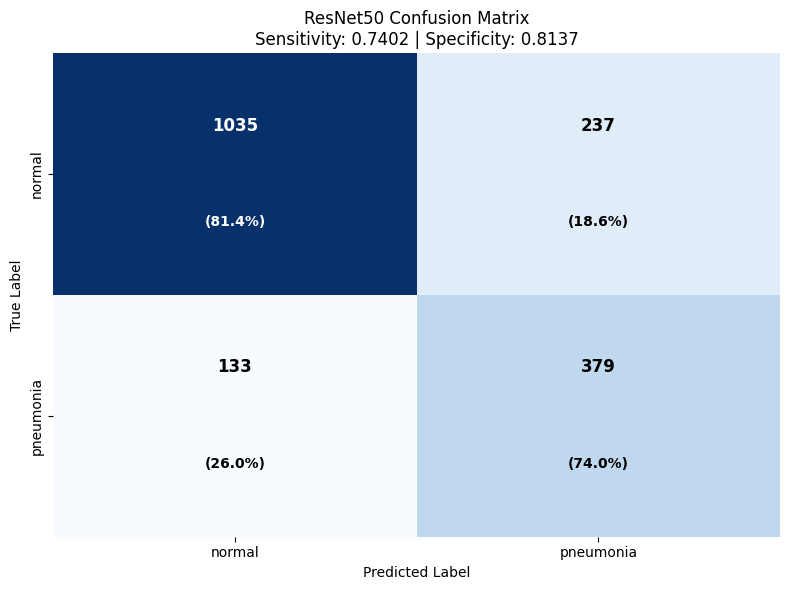

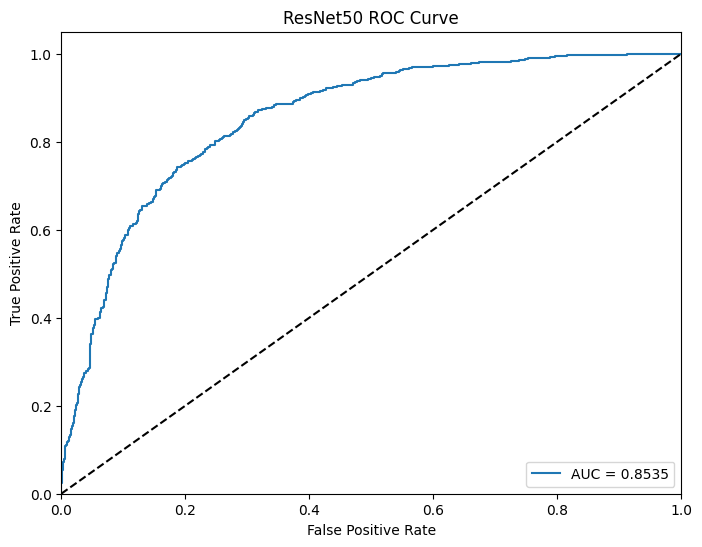


Evaluating DenseNet121...
DenseNet121 Results:
Test Accuracy: 76.29%
AUC Score: 0.8364

Classification Report:
              precision    recall  f1-score   support

           0     0.9001    0.7508    0.8187      1272
           1     0.5615    0.7930    0.6575       512

    accuracy                         0.7629      1784
   macro avg     0.7308    0.7719    0.7381      1784
weighted avg     0.8029    0.7629    0.7724      1784


Confusion Matrix:
[[955 317]
 [106 406]]
Accuracy: 0.7629
Sensitivity: 0.7930
Specificity: 0.7508


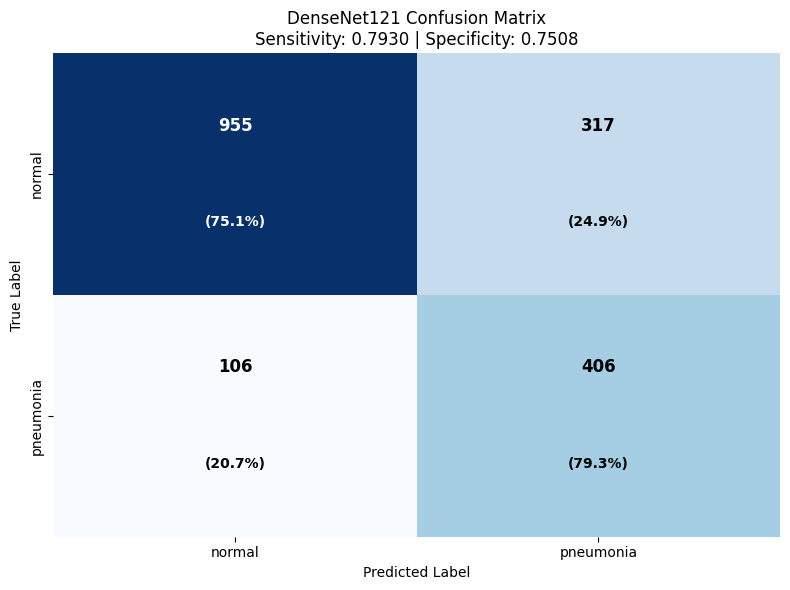

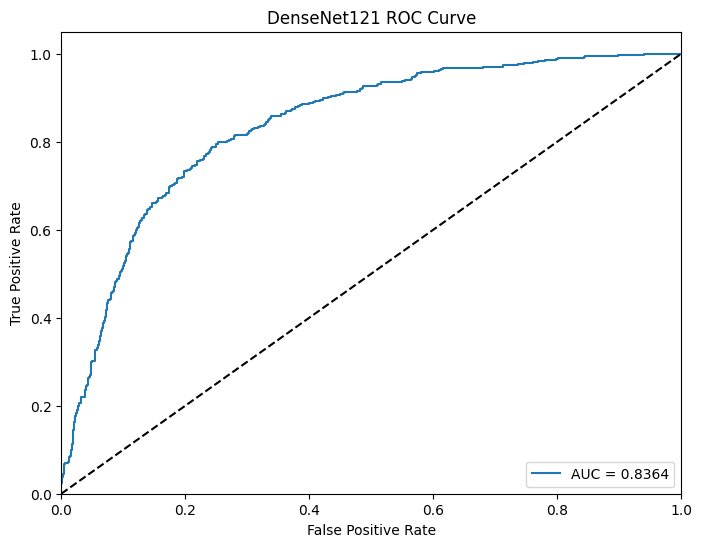


Evaluating InceptionV3...
InceptionV3 Results:
Test Accuracy: 71.75%
AUC Score: 0.8242

Classification Report:
              precision    recall  f1-score   support

           0     0.9103    0.6698    0.7717      1272
           1     0.5047    0.8359    0.6294       512

    accuracy                         0.7175      1784
   macro avg     0.7075    0.7529    0.7006      1784
weighted avg     0.7939    0.7175    0.7309      1784


Confusion Matrix:
[[852 420]
 [ 84 428]]
Accuracy: 0.7175
Sensitivity: 0.8359
Specificity: 0.6698


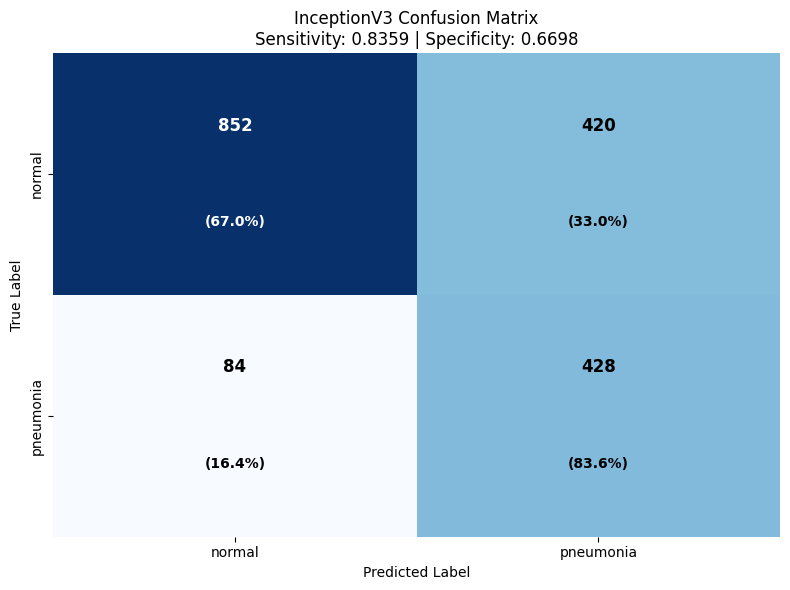

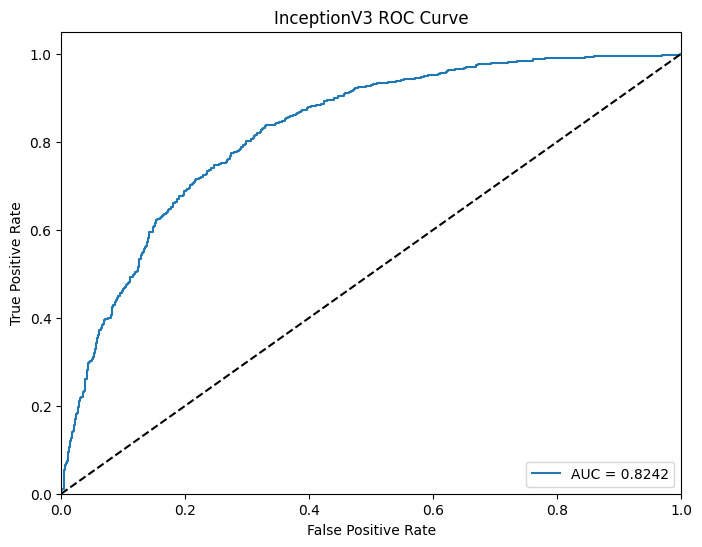


Evaluating Xception...
Xception Results:
Test Accuracy: 76.35%
AUC Score: 0.8436

Classification Report:
              precision    recall  f1-score   support

           0     0.9071    0.7445    0.8178      1272
           1     0.5608    0.8105    0.6629       512

    accuracy                         0.7635      1784
   macro avg     0.7339    0.7775    0.7404      1784
weighted avg     0.8077    0.7635    0.7733      1784


Confusion Matrix:
[[947 325]
 [ 97 415]]
Accuracy: 0.7635
Sensitivity: 0.8105
Specificity: 0.7445


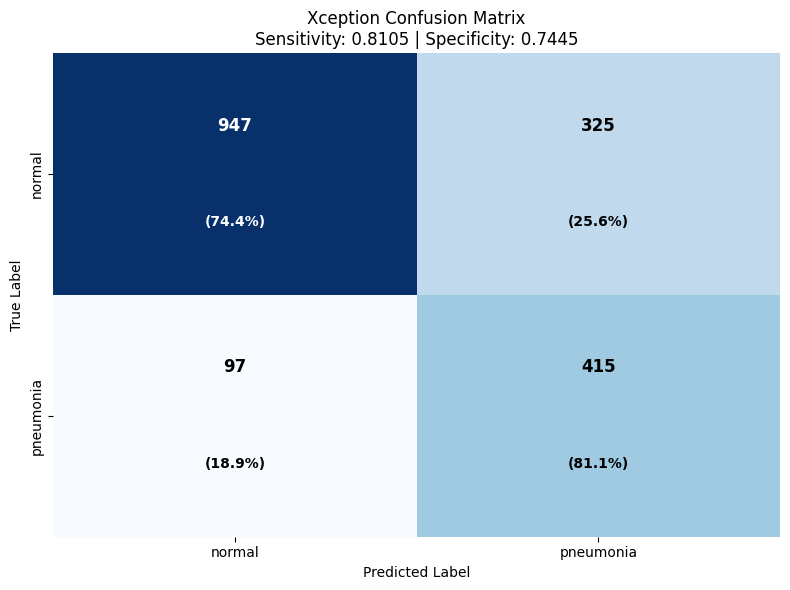

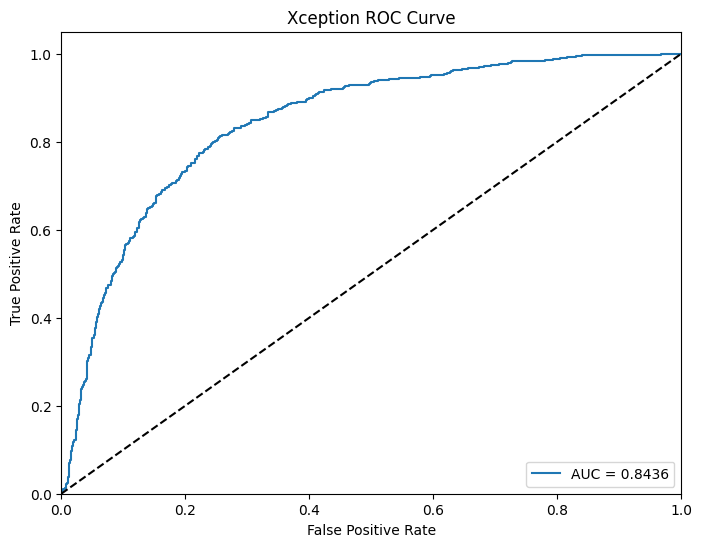


Evaluating MobileNetV2...
MobileNetV2 Results:
Test Accuracy: 73.21%
AUC Score: 0.7930

Classification Report:
              precision    recall  f1-score   support

           0     0.8759    0.7272    0.7947      1272
           1     0.5234    0.7441    0.6145       512

    accuracy                         0.7321      1784
   macro avg     0.6996    0.7357    0.7046      1784
weighted avg     0.7748    0.7321    0.7430      1784


Confusion Matrix:
[[925 347]
 [131 381]]
Accuracy: 0.7321
Sensitivity: 0.7441
Specificity: 0.7272


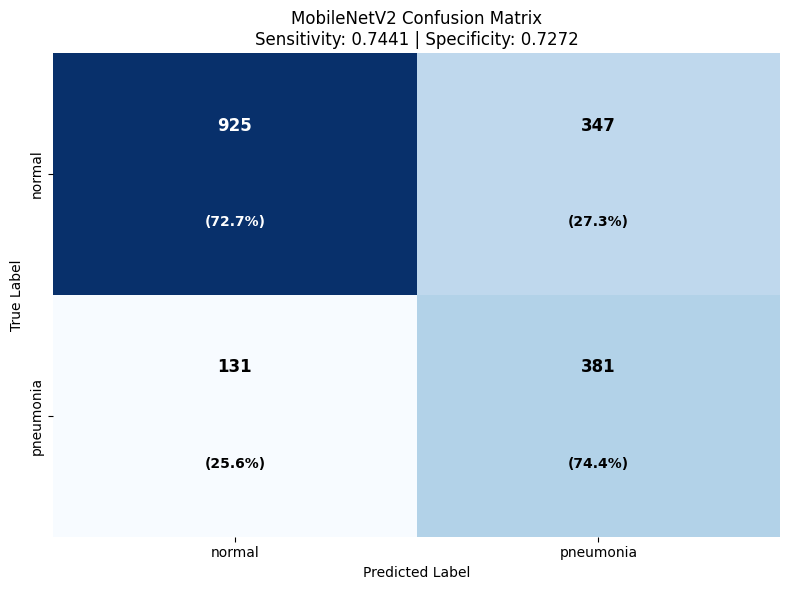

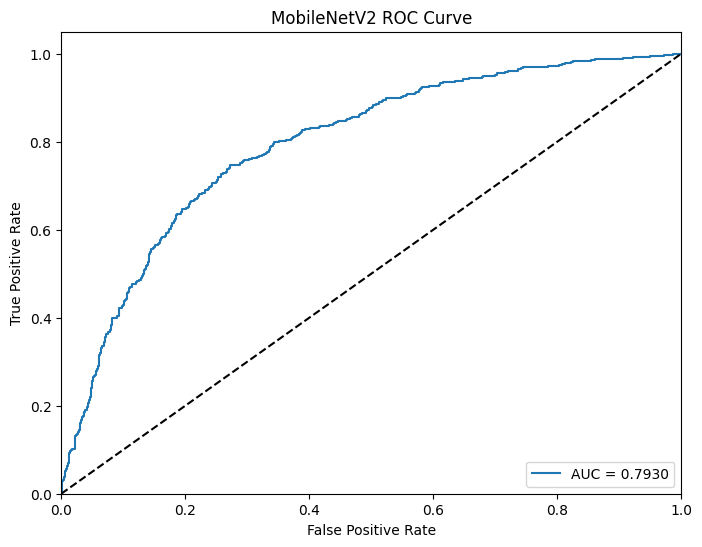


SUMMARY OF INDIVIDUAL MODEL PERFORMANCES

Performance Summary Table:
      Model Accuracy    AUC Sensitivity Specificity
   ResNet50   79.26% 0.8535      0.7402      0.8137
DenseNet121   76.29% 0.8364      0.7930      0.7508
InceptionV3   71.75% 0.8242      0.8359      0.6698
   Xception   76.35% 0.8436      0.8105      0.7445
MobileNetV2   73.21% 0.7930      0.7441      0.7272


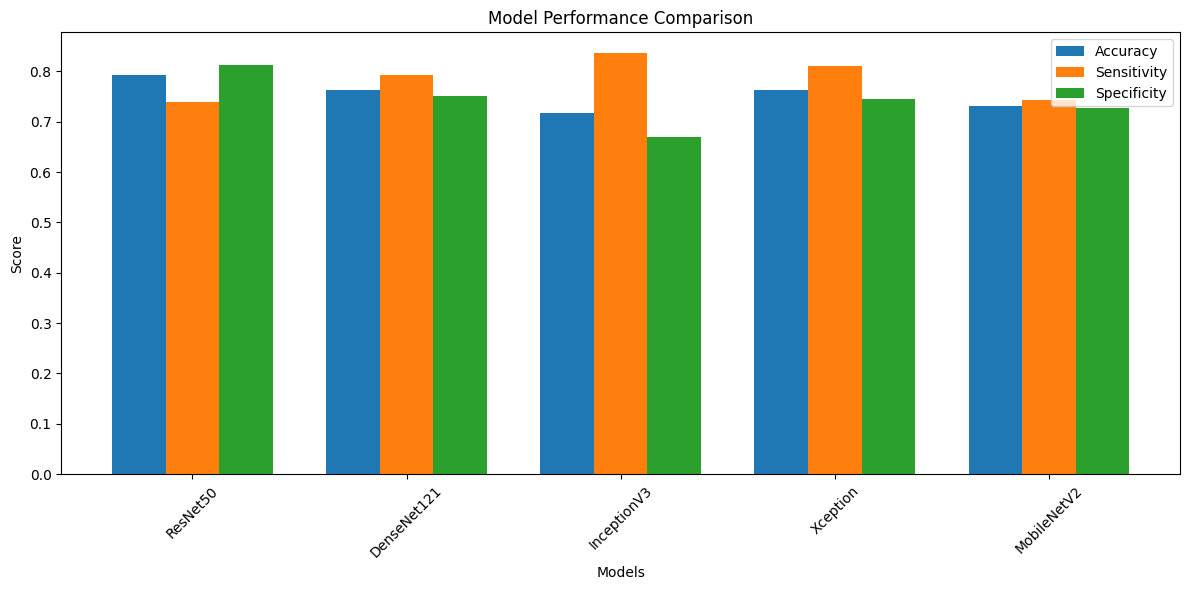


Individual model evaluation completed!


In [ ]:
## Individual with optimal THRESHOLD**##
# Individual Model Evaluation
print("\nEvaluating individual models on test set...")

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a raw test generator (no preprocessing)
raw_test_gen = ImageDataGenerator().flow_from_directory(
    TEST_PATH,
    target_size=(299, 299),  # Use a standard size, will resize for each model
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate each model individually
model_performances = {}

for i, (model, config) in enumerate(zip(trained_models, model_configs)):
    if model is None:
        print(f"Skipping {config['name']} - model not loaded")
        continue

    print(f"\nEvaluating {config['name']}...")

    # Reset generator for each model
    raw_test_gen.reset()
    test_count = raw_test_gen.samples
    steps_test = test_count // BATCH_SIZE + (1 if test_count % BATCH_SIZE != 0 else 0)

    all_predictions = []
    true_labels = []

    batch_counter = 0
    for batch_data, batch_labels in raw_test_gen:
        if batch_counter >= steps_test:
            break

        true_labels.extend(np.argmax(batch_labels, axis=1))

        # Preprocess for this specific model
        resized = tf.image.resize(batch_data, config['target_size'])
        resized = tf.cast(resized, tf.float32)
        preprocessed = config['preprocess_func'](resized)

        # Predict
        pred = model.predict(preprocessed, verbose=0)
        all_predictions.append(pred)

        batch_counter += 1

    # Combine results
    all_predictions = np.vstack(all_predictions)
    true_labels = np.array(true_labels)

    # Apply optimal threshold to balance sensitivity and specificity
    if len(np.unique(true_labels)) > 1:
        fpr, tpr, thresholds = roc_curve(true_labels, all_predictions[:, 1])
        # Find threshold that maximizes the difference between TPR and FPR (Youden's J statistic)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        # Use optimal threshold for predictions
        predicted_labels = (all_predictions[:, 1] > optimal_threshold).astype(int)
    else:
        # Fallback to argmax if only one class present
        predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    accuracy = np.mean(predicted_labels == true_labels)

    if len(np.unique(true_labels)) > 1:
        auc_score = roc_auc_score(true_labels, all_predictions[:, 1])
    else:
        auc_score = "N/A"

    # Classification report
    print(f"{config['name']} Results:")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"AUC Score: {auc_score if isinstance(auc_score, str) else f'{auc_score:.4f}'}")

    # Add classification report with 4 significant figures
    print("\nClassification Report:")
    cr = classification_report(true_labels, predicted_labels, digits=4)
    print(cr)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    total = cm.sum()
    acc = (cm[0, 0] + cm[1, 1]) / total if total > 0 else 0
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Store performance for comparison
    model_performances[config['name']] = {
        'accuracy': accuracy,
        'auc': auc_score if isinstance(auc_score, float) else 0,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    # Plot confusion matrix for each model with enhanced annotations
    plt.figure(figsize=(8, 6))
    class_names = labels if 'labels' in locals() else ['0', '1']

    # Create heatmap without annotations first
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add custom annotations with bold text and specific colors
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            row_sum = cm[i, :].sum()
            percentage = count / row_sum * 100 if row_sum > 0 else 0.0

            # Determine text color: white only for True Negative (top-left cell), black for all others
            text_color = 'white' if (i == 0 and j == 0) else 'black'

            # Add count (bold)
            ax.text(j + 0.5, i + 0.3, f'{count}',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=12,
                   fontweight='bold')

            # Add percentage (bold)
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                   horizontalalignment='center',
                   verticalalignment='center',
                   color=text_color,
                   fontsize=10,
                   fontweight='bold')

    auc_text = f"AUC: {auc_score:.4f}" if isinstance(auc_score, float) else f"AUC: {auc_score}"
    plt.title(f"{config['name']} Confusion Matrix\nSensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/{config['name']}_confusion_matrix.png")
    plt.show()

    # Plot ROC curve if applicable
    if isinstance(auc_score, float):
        fpr, tpr, thresholds = roc_curve(true_labels, all_predictions[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{config["name"]} ROC Curve')
        plt.legend(loc="lower right")
        plt.savefig(f"/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/{config['name']}_roc_curve.png")
        plt.show()

# Create a summary table of all model performances
print("\n" + "="*80)
print("SUMMARY OF INDIVIDUAL MODEL PERFORMANCES")
print("="*80)

# Prepare data for table
summary_data = []
for model_name, metrics in model_performances.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']*100:.2f}%",
        'AUC': f"{metrics['auc']:.4f}" if metrics['auc'] > 0 else 'N/A',
        'Sensitivity': f"{metrics['sensitivity']:.4f}",
        'Specificity': f"{metrics['specificity']:.4f}"
    })

# Create and display DataFrame
df_summary = pd.DataFrame(summary_data)
print("\nPerformance Summary Table:")
print(df_summary.to_string(index=False))

# Create a comparison plot
if model_performances:
    models = list(model_performances.keys())
    accuracies = [model_performances[m]['accuracy'] for m in models]
    sensitivities = [model_performances[m]['sensitivity'] for m in models]
    specificities = [model_performances[m]['specificity'] for m in models]

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, sensitivities, width, label='Sensitivity')
    plt.bar(x + width, specificities, width, label='Specificity')

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
   # plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/model_comparison.png")
    plt.show()

print("\nIndividual model evaluation completed!")

In [ ]:
# Add this print statement right after the optimal threshold is calculated
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Place it right after this line in your code:
optimal_threshold = thresholds[optimal_idx]

Optimal Threshold: 0.2120


#### **Model Size Analysis**


Analyzing model sizes...

INDIVIDUAL MODEL SIZES
ResNet50:
  File Size: 164.77 MB
  Parameters: 24,112,770
  Estimated Size: 91.98 MB

DenseNet121:
  File Size: 36.21 MB
  Parameters: 7,300,418
  Estimated Size: 27.85 MB

InceptionV3:
  File Size: 129.58 MB
  Parameters: 22,327,842
  Estimated Size: 85.17 MB

Xception:
  File Size: 154.31 MB
  Parameters: 21,386,538
  Estimated Size: 81.58 MB

MobileNetV2:
  File Size: 20.88 MB
  Parameters: 2,586,434
  Estimated Size: 9.87 MB


META-LEARNER SIZE
Meta-learner:
  File Size: 0.15 MB
  Parameters: 9,794.0
  Estimated Size: 0.04 MB

OPTUNA WEIGHTS SIZE
Optuna Weights File Size: 0.000160 MB

NUCLEAR ENSEMBLE TOTAL SIZE
Total Individual Models Size: 505.75 MB
Meta-learner Size: 0.15 MB
Optuna Weights Size: 0.000160 MB
Total Nuclear Ensemble Size: 505.89 MB
Total Parameters: 77,723,796.0

MODEL SIZE SUMMARY
                 Model File Size (MB)   Parameters Estimated Size (MB)
              ResNet50         164.77   24,112,770               

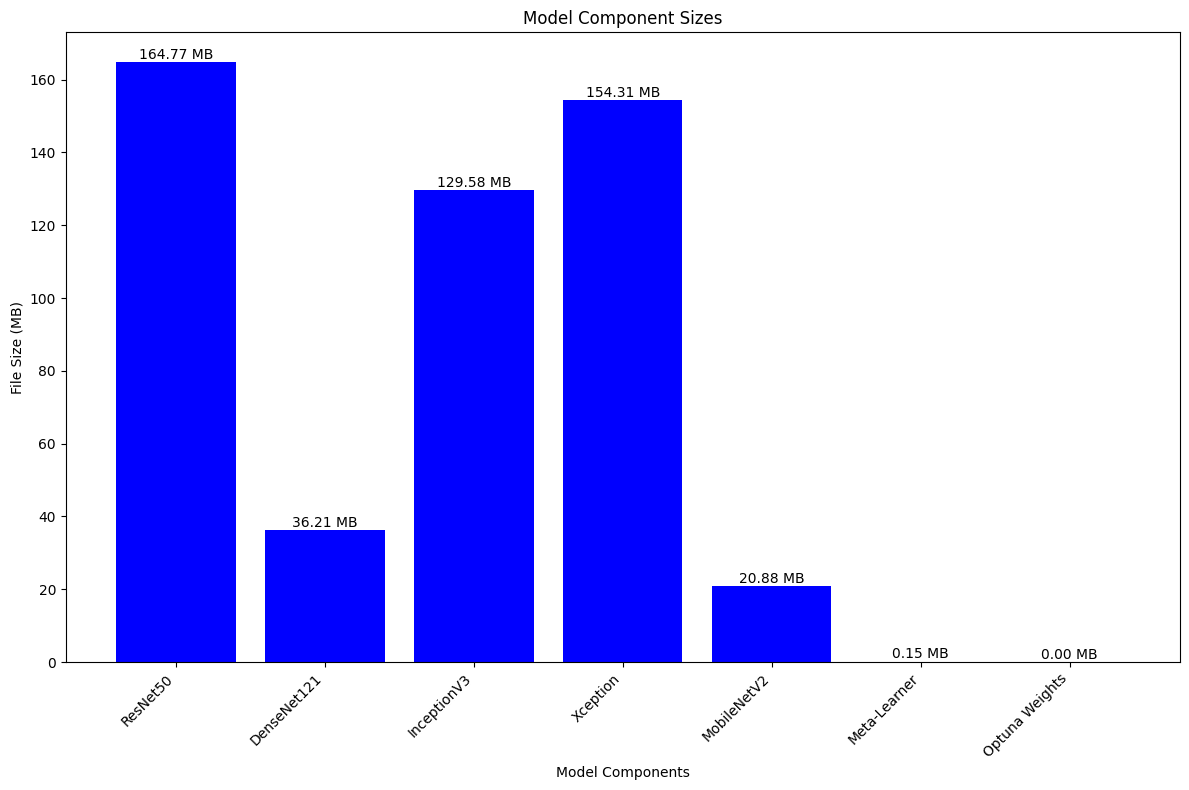


Model size analysis completed!


In [ ]:
# Model Size Analysis
print("\nAnalyzing model sizes...")

import os
from pathlib import Path

def get_file_size(file_path):
    """Get file size in MB"""
    if os.path.exists(file_path):
        size_bytes = os.path.getsize(file_path)
        size_mb = size_bytes / (1024 * 1024)
        return size_mb
    return 0

def get_model_size(model):
    """Get model size by counting parameters and estimating size"""
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params

    # Estimate size in MB (assuming float32 = 4 bytes per parameter)
    estimated_size_mb = (total_params * 4) / (1024 * 1024)
    return total_params, estimated_size_mb

# Directory where models are saved
models_dir = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models"

# Analyze individual model sizes
print("\n" + "="*60)
print("INDIVIDUAL MODEL SIZES")
print("="*60)

individual_model_sizes = {}
total_individual_size = 0
total_individual_params = 0

for i, (model, config) in enumerate(zip(trained_models, model_configs)):
    if model is None:
        continue

    # Get model file size
    model_files = [f for f in os.listdir(models_dir) if f.startswith(config['name']) and f.endswith('.keras')]
    if model_files:
        # Get the latest model file
        model_files.sort(key=lambda x: os.path.getmtime(os.path.join(models_dir, x)))
        model_file = model_files[-1]
        model_path = os.path.join(models_dir, model_file)
        file_size = get_file_size(model_path)

        # Get model parameter count and estimated size
        param_count, estimated_size = get_model_size(model)

        individual_model_sizes[config['name']] = {
            'file_size_mb': file_size,
            'param_count': param_count,
            'estimated_size_mb': estimated_size
        }

        total_individual_size += file_size
        total_individual_params += param_count

        print(f"{config['name']}:")
        print(f"  File Size: {file_size:.2f} MB")
        print(f"  Parameters: {param_count:,}")
        print(f"  Estimated Size: {estimated_size:.2f} MB")
        print()

# Analyze meta-learner size
print("\n" + "="*60)
print("META-LEARNER SIZE")
print("="*60)

meta_learner_path = os.path.join(models_dir, "meta_learner_model.keras")
meta_learner_size = get_file_size(meta_learner_path)

if meta_learner_size > 0:
    # Load meta-learner to get parameter count
    try:
        meta_model = tf.keras.models.load_model(meta_learner_path)
        meta_params, meta_estimated_size = get_model_size(meta_model)

        print(f"Meta-learner:")
        print(f"  File Size: {meta_learner_size:.2f} MB")
        print(f"  Parameters: {meta_params:,}")
        print(f"  Estimated Size: {meta_estimated_size:.2f} MB")
    except:
        print(f"Meta-learner File Size: {meta_learner_size:.2f} MB")
        print("  Could not load meta-learner for parameter count")
else:
    print("Meta-learner not found")

# Analyze Optuna weights size
print("\n" + "="*60)
print("OPTUNA WEIGHTS SIZE")
print("="*60)

optuna_weights_path = os.path.join(models_dir, "optimal_weights.npy")
optuna_weights_size = get_file_size(optuna_weights_path)

if optuna_weights_size > 0:
    print(f"Optuna Weights File Size: {optuna_weights_size:.6f} MB")
else:
    print("Optuna weights not found")

# Calculate total nuclear ensemble size
print("\n" + "="*60)
print("NUCLEAR ENSEMBLE TOTAL SIZE")
print("="*60)

total_nuclear_size = total_individual_size + meta_learner_size + optuna_weights_size
total_nuclear_params = total_individual_params + meta_params

print(f"Total Individual Models Size: {total_individual_size:.2f} MB")
print(f"Meta-learner Size: {meta_learner_size:.2f} MB")
print(f"Optuna Weights Size: {optuna_weights_size:.6f} MB")
print(f"Total Nuclear Ensemble Size: {total_nuclear_size:.2f} MB")
print(f"Total Parameters: {total_nuclear_params:,}")

# Create a summary table
print("\n" + "="*80)
print("MODEL SIZE SUMMARY")
print("="*80)

summary_data = []
for model_name, sizes in individual_model_sizes.items():
    summary_data.append({
        'Model': model_name,
        'File Size (MB)': f"{sizes['file_size_mb']:.2f}",
        'Parameters': f"{sizes['param_count']:,}",
        'Estimated Size (MB)': f"{sizes['estimated_size_mb']:.2f}"
    })

# Add meta-learner
summary_data.append({
    'Model': 'Meta-Learner',
    'File Size (MB)': f"{meta_learner_size:.2f}",
    'Parameters': f"{meta_params:,}",
    'Estimated Size (MB)': f"{meta_estimated_size:.2f}"
})

# Add Optuna weights
summary_data.append({
    'Model': 'Optuna Weights',
    'File Size (MB)': f"{optuna_weights_size:.6f}",
    'Parameters': 'N/A',
    'Estimated Size (MB)': f"{optuna_weights_size:.6f}"
})

# Add total
summary_data.append({
    'Model': 'TOTAL NUCLEAR ENSEMBLE',
    'File Size (MB)': f"{total_nuclear_size:.2f}",
    'Parameters': f"{total_nuclear_params:,}",
    'Estimated Size (MB)': f"{total_nuclear_size:.2f}"
})

# Create and display DataFrame
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

# Create a visualization of model sizes
if individual_model_sizes:
    models = list(individual_model_sizes.keys()) + ['Meta-Learner', 'Optuna Weights']
    sizes = [individual_model_sizes[m]['file_size_mb'] for m in individual_model_sizes.keys()] + [meta_learner_size, optuna_weights_size]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, sizes, color=['blue']*len(individual_model_sizes) + ['green', 'orange'])
    plt.xlabel('Model Components')
    plt.ylabel('File Size (MB)')
    plt.title('Model Component Sizes')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar, size in zip(bars, sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{size:.2f} MB', ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/NIH_processed/New_NIH_Models/ensemble_models/model_sizes.png")
    plt.show()

print("\nModel size analysis completed!")